In [1]:
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

    
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer




In [2]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

### Loading data and adding OpenAI vector embeddings

In [3]:
df = pd.read_csv('survey data.csv')

# Add row number and combine with userid to create custom_id
df['custom_id'] = df.reset_index().apply(lambda x: f"{x.name}_{x['userid']}", axis=1)

# Verify the new custom_id column
print("\nFirst few rows with new custom_id:")
print(df[['custom_id', 'userid']].head())


First few rows with new custom_id:
             custom_id             userid
0  0_6097026029595349a  6097026029595349a
1  1_5825253472710824a  5825253472710824a
2  2_2445165941044480a  2445165941044480a
3  3_2256909313723761a  2256909313723761a
4  4_2785269061142869a  2785269061142869a


In [4]:
# Find duplicate userids
duplicates = df[df.duplicated(subset=['userid'], keep=False)]

# Sort by userid to group duplicates together
duplicates = duplicates.sort_values('userid')

# Display duplicate rows
print("Duplicate userids found:")
duplicates[['userid', 'group', 'Open_report typo-corrected', 'age', 'gender_1F_2M_3O', 'education_level', 'income_level', 'Country_birth', 'English_proficiency', 'religion']]


Duplicate userids found:


,userid,group,Open_report typo-corrected,age,gender_1F_2M_3O,education_level,income_level,Country_birth,English_proficiency,religion
107,1101963392402606a,psychedelics,I took a sugar cube that had drop of LSD infus...,35,1,7,4,Finland,3,4
165,1101963392402606a,psychedelics,I was in Amsterdam and took magic truffles. I ...,37,2,7,4,Finland,2,9
5,409304616362934a,meditation,Silence of mind and timelessness,63,2,3,4,Finland,4,1
173,409304616362934a,psychedelics,Made connection to my 'internal family',63,2,3,4,finland,4,3
14,8370990039980906a,meditation,This experience happened during my first medit...,29,1,7,1,Finland,3,999
202,8370990039980906a,psychedelics,"I had very difficult headaches those days, and...",29,1,7,2,Finland,3,999


In [5]:
# Drop all rows that have duplicate userids
initial_rows = len(df)
df = df[~df['userid'].isin(duplicates['userid'])]
dropped_rows = initial_rows - len(df)
remaining_rows = len(df)
print(f"Dropped {dropped_rows} rows with duplicate userids")
print(f"Remaining rows: {remaining_rows}")

Dropped 6 rows with duplicate userids
Remaining rows: 207


In [6]:
# Drop rows where Open_report typo-corrected is null
initial_rows = len(df)
df = df.dropna(subset=['Open_report typo-corrected'])
dropped_rows = initial_rows - len(df)
remaining_rows = len(df)
print(f"Dropped {dropped_rows} rows with null values in Open_report typo-corrected")
print(f"Remaining rows: {remaining_rows}")

Dropped 10 rows with null values in Open_report typo-corrected
Remaining rows: 197


In [7]:
# Select columns to feed to OpenAI 
openai_embeddings_input = df[['custom_id', 'Open_report typo-corrected']]

# Check for duplicate userids
duplicate_users = openai_embeddings_input[openai_embeddings_input.duplicated(subset=['custom_id'], keep=False)]

if len(duplicate_users) > 0:
    print(f"Found {len(duplicate_users)} rows with duplicate custom_ids:")
    print(duplicate_users)
else:
    print("No duplicate custom_ids found")

No duplicate custom_ids found


In [8]:
# Create JSONL file for OpenAI batch processing with ada-002
import json

# Create JSONL file
with open('openai_input.jsonl', 'w', encoding='utf-8') as f:
    for _, row in openai_embeddings_input.iterrows():
        # Create dictionary with required format
        json_obj = {
            "custom_id": row['custom_id'],
            "method": "POST",
            "url": "/v1/embeddings",
            "body": {
                "model": "text-embedding-ada-002",
                "input": row['Open_report typo-corrected']
            }
        }
        # Write each object as a new line in JSONL format
        f.write(json.dumps(json_obj) + '\n')

#### The vector embeddings were done using OpenAI batch processing on their web platform
https://platform.openai.com/batches

In [9]:
# Read the JSONL file and parse the nested structure
embeddings_list = []
with open('openai_output.jsonl', 'r') as file:
    for line in file:
        data = json.loads(line)
        embedding_data = {
            'custom_id': data['custom_id'],
            'embedding': data['response']['body']['data'][0]['embedding']
        }
        embeddings_list.append(embedding_data)

# Convert to DataFrame
embeddings_df = pd.DataFrame(embeddings_list)

# Verify the data
print("Shape of embeddings dataframe:", embeddings_df.shape)
print("\nSample row:")
print(embeddings_df.sample(5))

Shape of embeddings dataframe: (203, 2)

Sample row:
                 custom_id                                          embedding
91    92_9525534592600660a  [-0.0003867352, -0.009762313, 0.015394938, -0....
160  167_3256565712836655a  [-0.0053436225, -0.010917007, -0.0005190174, -...
154   161_656924354902436a  [-0.0003533506, -0.010038995, 0.019210257, -0....
0      0_6097026029595349a  [0.0020260897, -0.010788355, 0.023697723, 0.00...
197  206_5773904834498301a  [0.012550909, -0.019599874, 0.009573386, -0.03...


In [10]:
# Merge embeddings with main dataframe
df = pd.merge(df, embeddings_df, on='custom_id', how='left')


df.sample()

,variant,group,age,gender_1F_2M_3O,education_level,education_level_otherSpecification,income_level,Country_birth,English_proficiency,religion,religion_other_spec,meditation_freq,meditation_howlong,medit_type_silent,medit_type_voice,medit_type_breath,medit_type_body,medit_type_mindfulness,bg_medit_type_other,classicalPsych_frequency,TimeSinceLastClassicalPsych,Psychiatric_No_disclosure,Psychiatric_severe_depression,Psychiatric_bipolar,Psychiatric_psychosis,Psychiatric_anxiety,Psychiatric_ASD,Psychiatric_OCD,Psychiatric_ADHD,psychiatric_other,psychiatric_selfdiagnosed,substance_use_problem,ESP1_INV,2 ESP,3 ESP,4 ESP,exp_LSD,exp_psilocybin,exp_ayahuasca,exp_DMT,exp_5meoDMT,exp_mescaline,exp_ibogaine,exp_salvia,exp_mdma,exp_ketamine,exp_cannabis,other_drug_dummy,exp_other_drug,how_many_drugs,exp_drug_dose,exp_drug_dose_specific,exp_drug_intensity,exp_drug_confidence,exp_medit_silent,exp_medit_voice,exp_medit_breath,exp_medit_body,exp_medit_mindfulness,exp_other_medit,exp_meditation_technique_specific,exp_medit_drug,exp_medit_drugSpecification,exp_when,exp_where,exp_who,exp_guide,exp_purpose_nospecific,exp_purpose_relax_enjoy,exp_purpose_spiritual,exp_purpose_therapeutic,exp_purpose_curiosity,exp_purpose_social,exp_purpose_selfimprovement,exp_purpose_distraction,exp_purpose_other,exp_other_purpose,exp_planned,exp_expect,exp_drug_meditation,exp_drug_medit_silent,exp_drug_medit_voice,exp_drug_medit_breath,exp_drug_medit_body,exp_drug_medit_mindfulness,exp_drug_medit_otherSpecify,Open_report,Open_report typo-corrected,open_report_characters,body_yes_no,Thematic_body,insight_yes_no,Thematic_insights,connection_or_alienation_yes_no,Thematic_connection,preposts_satisfied,preposts_positive,preposts_negative,preposts_meaning,preposts_peace_harmony,prepost_bodydissat,prepost_bodyappre,prepost_embodiment,MEQ30_Q1_mystical,MEQ30_Q2_mystical,MEQ30_Q3_mystical,MEQ30_Q4_mystical,MEQ30_Q5_mystical,MEQ30_Q6_mystical,MEQ30_Q7_mystical,MEQ30_Q8_mystical,MEQ30_Q9_mystical,MEQ30_Q10_mystical,MEQ30_Q11_mystical,MEQ30_Q12_mystical,MEQ30_Q13_mystical,MEQ30_Q14_mystical,MEQ30_Q15_mystical,MEQ30_Q16_positive_mood,MEQ30_Q17_positive_mood,MEQ30_Q18_positive_mood,MEQ30_Q19_positive_mood,MEQ30_Q20_positive_mood,MEQ30_Q21_positive_mood,MEQ30_Q22_transcendence,MEQ30_Q23_transcendence,MEQ30_Q24_transcendence,MEQ30_Q25_transcendence,MEQ30_Q26_transcendence,MEQ30_Q27_transcendence,MEQ30_Q28_ineffability,MEQ30_Q29_ineffability,MEQ30_Q30_ineffability,MEQ30_sum,WEMWBS_optimistic,WEMWBS_useful,WEMWBS_relaxed,WEMWBS_dealing_w_problems,WEMWBS_thinking_clearly,WEMWBS_close_to_others,WEMWBS_make_up_my_own_mind,PoMS_1,PoMS_2,PoMS_3,PoMS_4,PoMS_5_INV,PoMS_6,PoMS_7_INV,BAS1,BAS2,BAS3,BAS4,BAS5,BAS6,BAS7,BAS8,BAS9,BAS10,psy_flex1,psy_flex2,psy_flex3,psy_flex4,psy_flex5,psy_flex6,SVS_1_Power,userid,custom_id,embedding
187,psy3,psychedelics,47,2,3,NaN,5,Finland,2,9,NaN,1,6,1,0,0,0,0,NaN,3,0,0,0,0,0,0,0,0,0,NaN,NaN,3,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LSA,single,3.0,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,1,1,0,0,0,0,0,1,0,0,0,0,NaN,2,2,1.0,1.0,0.0,0.0,0.0,0.0,NaN,This took place many years ago at a friend's p...,This took place many years ago at a friend's p...,2040,1,I felt my body (as everything else) with lot m...,1,"There is more to the world than what we see, b...",1,I felt very close to my friend and that he was...,5.0,5.0,1.0,4.0,5.0,3.0,3.0,3.0,3.0,0.0,3.0,3.0,5.0,5.0,3.0,5.0,5.0,5.0,5.0,5.0,3.0,3.0,5.0,5.0,5.0,3.0,4.0,5.0,4.0,3.0,1.0,0.0,0.0,0.0,0.0,5.0,5.0,5.0,103.0,3,5,3,3,4,5,4,3,3,2,4,1,3,2,4,4,5,5,4,5,5,4,4,5,5,5,5,5,4,4,3,9362069377930580a,201_9362069377930580a,"[0.0024481914, -0.016567348, 0.015835665, -0.0..."


### Data cleanup

In [11]:
# Only keeping the columns that we need

columns_to_keep = ['custom_id', 'group', 'embedding', 'age', 'gender_1F_2M_3O', 'Country_birth', 'income_level', 'education_level', 'classicalPsych_frequency', 'TimeSinceLastClassicalPsych', 'meditation_freq', 'meditation_howlong', 
                'exp_LSD', 'exp_psilocybin', 'exp_ayahuasca', 'exp_DMT', 'exp_5meoDMT', 'exp_mescaline', 'exp_ibogaine', 'exp_salvia', 'exp_mdma', 'exp_ketamine', 'exp_cannabis', 'other_drug_dummy', 'exp_other_drug', 'how_many_drugs',
                'exp_medit_silent', 'exp_medit_voice', 'exp_medit_breath', 'exp_medit_body', 'exp_medit_mindfulness', 'exp_other_medit', 'exp_where', 'exp_who', 'exp_guide', 'MEQ30_sum', 'Open_report typo-corrected',
                'MEQ30_Q1_mystical', 'MEQ30_Q2_mystical', 'MEQ30_Q3_mystical', 'MEQ30_Q4_mystical', 'MEQ30_Q5_mystical', 'MEQ30_Q6_mystical', 'MEQ30_Q7_mystical', 'MEQ30_Q8_mystical', 'MEQ30_Q9_mystical', 'MEQ30_Q10_mystical',
                'MEQ30_Q11_mystical', 'MEQ30_Q12_mystical', 'MEQ30_Q13_mystical', 'MEQ30_Q14_mystical', 'MEQ30_Q15_mystical', 'MEQ30_Q16_positive_mood', 'MEQ30_Q17_positive_mood', 'MEQ30_Q18_positive_mood', 'MEQ30_Q19_positive_mood',
                'MEQ30_Q20_positive_mood', 'MEQ30_Q21_positive_mood', 'MEQ30_Q22_transcendence', 'MEQ30_Q23_transcendence', 'MEQ30_Q24_transcendence', 'MEQ30_Q25_transcendence', 'MEQ30_Q26_transcendence', 'MEQ30_Q27_transcendence',
                'MEQ30_Q28_ineffability', 'MEQ30_Q29_ineffability', 'MEQ30_Q30_ineffability']

df = df[columns_to_keep] 

df.sample(5)

,custom_id,group,embedding,age,gender_1F_2M_3O,Country_birth,income_level,education_level,classicalPsych_frequency,TimeSinceLastClassicalPsych,meditation_freq,meditation_howlong,exp_LSD,exp_psilocybin,exp_ayahuasca,exp_DMT,exp_5meoDMT,exp_mescaline,exp_ibogaine,exp_salvia,exp_mdma,exp_ketamine,exp_cannabis,other_drug_dummy,exp_other_drug,how_many_drugs,exp_medit_silent,exp_medit_voice,exp_medit_breath,exp_medit_body,exp_medit_mindfulness,exp_other_medit,exp_where,exp_who,exp_guide,MEQ30_sum,Open_report typo-corrected,MEQ30_Q1_mystical,MEQ30_Q2_mystical,MEQ30_Q3_mystical,MEQ30_Q4_mystical,MEQ30_Q5_mystical,MEQ30_Q6_mystical,MEQ30_Q7_mystical,MEQ30_Q8_mystical,MEQ30_Q9_mystical,MEQ30_Q10_mystical,MEQ30_Q11_mystical,MEQ30_Q12_mystical,MEQ30_Q13_mystical,MEQ30_Q14_mystical,MEQ30_Q15_mystical,MEQ30_Q16_positive_mood,MEQ30_Q17_positive_mood,MEQ30_Q18_positive_mood,MEQ30_Q19_positive_mood,MEQ30_Q20_positive_mood,MEQ30_Q21_positive_mood,MEQ30_Q22_transcendence,MEQ30_Q23_transcendence,MEQ30_Q24_transcendence,MEQ30_Q25_transcendence,MEQ30_Q26_transcendence,MEQ30_Q27_transcendence,MEQ30_Q28_ineffability,MEQ30_Q29_ineffability,MEQ30_Q30_ineffability
38,41_9442188169847298a,meditation,"[6.445986e-05, 0.0032238357, 0.018308287, -0.0...",59,2,UK,1,999,3,0,6,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,single,0.0,0.0,0.0,0.0,0.0,Nothing at all. Utterly 'spontaneous' experience,0,0,0,138.0,I awoke in the middle of the night with my con...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,5.0,5.0,5.0,0.0,5.0,5.0,5.0,4.0,4.0,4.0,4.0,5.0,4.0,5.0,4.0,5.0
154,164_2276593947183204a,psychedelics,"[-0.0026312403, -0.010172205, 0.022063294, -0....",26,2,Finland,5,7,3,0,2,6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,single,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,37.0,A feeling of that there was no way to achieve ...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,4.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,3.0,3.0,3.0,0.0,0.0,1.0,0.0,0.0,4.0,4.0,4.0
97,100_9913169910499478a,psychedelics,"[0.0026075274, -0.013366679, 0.017394539, -0.0...",54,1,South africa,3,999,1,0,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,single,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,28.0,I was given a joint...did not know this was la...,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,0.0,4.0,0.0,2.0,0.0,1.0,1.0,3.0,2.0,2.0,2.0,0.0,2.0,0.0,0.0,0.0
170,183_8899106400600072a,psychedelics,"[0.004660756, 0.007201751, 0.025763245, -0.027...",38,2,Sweden,1,999,5,1,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,single,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,76.0,I opened notepad on my computer to write down ...,4.0,5.0,5.0,2.0,1.0,0.0,0.0,2.0,0.0,1.0,3.0,3.0,4.0,4.0,3.0,5.0,4.0,4.0,4.0,4.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,4.0
33,35_76043125893358a,meditation,"[-0.012206694, -0.0112682255, -0.0045865974, -...",60,1,United States,1,999,1,0,5,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,single,0.0,0.0,1.0,0.0,0.0,"Gardening, walking, cooking",5,3,2,140.0,I was on a mat for Holotropic Breathwork ®. My...,5.0,3.0,5.0,5.0,5.0,5.0,5.0,3.0,3.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,3.0,5.0,3.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0


In [12]:
# Editing minor issues manually in the reports which came up while running some preliminary analyses  

# Replacing the abbreviation gf with the actual word girlfriend
df['Open_report typo-corrected'] = df['Open_report typo-corrected'].str.replace('gf ', 'girlfriend ')
df['Open_report typo-corrected'] = df['Open_report typo-corrected'].str.replace('gf)', 'girlfriend)')

# Someone had constantly used a Finnish word in their report written in English 
df['Open_report typo-corrected'] = df['Open_report typo-corrected'].str.replace('unihalvaus', 'sleep paralysis')


In [13]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197 entries, 0 to 196
Data columns (total 67 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   custom_id                    197 non-null    object 
 1   group                        197 non-null    object 
 2   embedding                    197 non-null    object 
 3   age                          197 non-null    int64  
 4   gender_1F_2M_3O              197 non-null    int64  
 5   Country_birth                195 non-null    object 
 6   income_level                 197 non-null    int64  
 7   education_level              197 non-null    int64  
 8   classicalPsych_frequency     197 non-null    int64  
 9   TimeSinceLastClassicalPsych  197 non-null    int64  
 10  meditation_freq              197 non-null    int64  
 11  meditation_howlong           197 non-null    int64  
 12  exp_LSD                      134 non-null    float64
 13  exp_psilocybin      

In [14]:
# Group columns need to be in type category for the split into two dataframes in the next cell. Open reports need to have the string type for further analysis. 
df.loc[:, 'group'] = df['group'].astype('category')
df.loc[:, 'Open_report typo-corrected'] = df['Open_report typo-corrected'].astype('string')

In [ ]:
# # Print all open reports with their group labels, wrapping text at 80 characters
# for index, row in df.iterrows():
#     print(f"\nGroup: {row['group']}")
#     print("Report:")
    
#     # Get the report text and split into words
#     report = row['Open_report typo-corrected']
#     words = report.split()
    
#     # Build lines up to 80 chars
#     current_line = []
#     current_length = 0
    
#     for word in words:
#         # Check if adding this word would exceed line length
#         if current_length + len(word) + 1 <= 80:
#             current_line.append(word)
#             current_length += len(word) + 1
#         else:
#             # Print current line and start new one
#             print(' '.join(current_line))
#             current_line = [word]
#             current_length = len(word) + 1
            
#     # Print final line if any words remain
#     if current_line:
#         print(' '.join(current_line))
        
#     print("-" * 80)  # Print a separator line between reports



Group: meditation
Report:
There is a fundamental concept in Buddhism called anicca regarded as a basic
truth of all things. To me it means change. The experiencing of all things
changing is transforming. I woke up to experiencing my entire mind body
phenomenon changing on every moment. Since then this experience has become
routine. With it comes a letting go of past suppressive habits and instead a
fluidity and serenity is there.
--------------------------------------------------------------------------------

Group: meditation
Report:
I developed all positive feelings. All thoughts in my mind looked like they
were visible on a screen and I could for the first time in my life feel the
bliss.
--------------------------------------------------------------------------------

Group: meditation
Report:
I had recently lost my father unexpectedly. A month after his funeral I
attended an empowerment and retreat for a ngondro that involved meditating on
the 4 thoughts that turn the mind. I spe

In [16]:
# Creating separate dataframes for psychedelics and meditation groups

psyke = df[df['group']=='psychedelics']

medi = df[df['group']=='meditation']

psyke_count = len(psyke)
medi_count = len(medi)

print(f"Number of reports in 'psychedelics' group: {psyke_count}")
print(f"Number of reports in 'meditation' group: {medi_count}")

Number of reports in 'psychedelics' group: 134
Number of reports in 'meditation' group: 63


## Demographic data about the participants

#### Data formatting and cleaning

In [17]:
# Replace gender codes with actual values for both groups
psyke['gender_1F_2M_3O'].replace({1: 'female', 2: 'male', 3: 'other'}, inplace=True)
medi['gender_1F_2M_3O'].replace({1: 'female', 2: 'male', 3: 'other'}, inplace=True)


/var/folders/mn/1s5j3ljx1c796bd743f0ymxh0000gn/T/ipykernel_96621/1785505734.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  psyke['gender_1F_2M_3O'].replace({1: 'female', 2: 'male', 3: 'other'}, inplace=True)
/var/folders/mn/1s5j3ljx1c796bd743f0ymxh0000gn/T/ipykernel_96621/1785505734.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  medi['gender_1F_2M_3O'].replace({1: 'female', 2: 'male', 3: 'other'}, inplace=True)


In [18]:
# Manually editing few rows where participants didn't know how to fill the survey correctly


psyke.loc[psyke.index == 120, 'exp_cannabis'] = 1
psyke.loc[psyke.index == 120, 'exp_other_drug'] = None
psyke.loc[psyke.index == 120, 'other_drug_dummy'] = 0

psyke.loc[psyke.index == 121, 'exp_other_drug'] = None
psyke.loc[psyke.index == 121, 'other_drug_dummy'] = 0

psyke.loc[psyke.index == 126, 'exp_other_drug'] = None
psyke.loc[psyke.index == 126, 'other_drug_dummy'] = 0

psyke.loc[psyke.index == 125, 'exp_cannabis'] = 1
psyke.loc[psyke.index == 125, 'exp_other_drug'] = None
psyke.loc[psyke.index == 125, 'other_drug_dummy'] = 0

psyke.loc[psyke.index == 156, 'exp_DMT'] = 1
psyke.loc[psyke.index == 156, 'exp_other_drug'] = None
psyke.loc[psyke.index == 156, 'other_drug_dummy'] = 0

psyke.loc[psyke.index == 167, 'exp_DMT'] = 1
psyke.loc[psyke.index == 167, 'exp_other_drug'] = None
psyke.loc[psyke.index == 167, 'other_drug_dummy'] = 0


In [19]:
# Checking that the other drug answers look correct now
drug_columns = ['exp_LSD', 'exp_psilocybin', 'exp_ayahuasca', 'exp_DMT', 'exp_5meoDMT', 'exp_mescaline', 'exp_ibogaine', 'exp_salvia', 'exp_mdma', 'exp_ketamine', 'exp_cannabis', 'other_drug_dummy']

psyke_other_drug = psyke[psyke['other_drug_dummy'] == 1]

columns_to_show = drug_columns + ['exp_other_drug']
psyke_other_drug[columns_to_show]


,exp_LSD,exp_psilocybin,exp_ayahuasca,exp_DMT,exp_5meoDMT,exp_mescaline,exp_ibogaine,exp_salvia,exp_mdma,exp_ketamine,exp_cannabis,other_drug_dummy,exp_other_drug
82,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4-aco-dipt
110,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,Cocaine
148,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,This experience also included alcohol and amph...
152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Nitrous oxide


In [20]:
# Distribution of 'exp_where', 'exp_who', and 'exp_guide' variables for the psyke group (set and setting)

exp_where_mapped_answers = {
    0: 'home',
    1: 'friends home',
    2: 'unknown person home',
    3: 'other private space',
    4: 'nature',
    5: 'ceremonial space/retreat',
    6: 'therapeutic space',
    7: 'public gathering',
    8: 'other public space'
}

exp_who_mapped_answers = {
    0: 'alone',
    1: 'one other person',
    2: 'several people, all familiar',
    3: 'several people, some unfamiliar',
    4: 'several people, all unfamiliar'
}


# Create DataFrame for 'exp_where' with counts and relative distribution using mapped answers
exp_where_counts = psyke['exp_where'].map(exp_where_mapped_answers).value_counts()
exp_where_df = exp_where_counts.to_frame(name='count')
exp_where_df['percentage'] = (exp_where_df['count'] / exp_where_df['count'].sum()) * 100
print("\nDistribution of 'exp_where':\n", exp_where_df)

# Create DataFrame for 'exp_who' with counts and relative distribution using mapped answers
exp_who_counts = psyke['exp_who'].map(exp_who_mapped_answers).value_counts()
exp_who_df = exp_who_counts.to_frame(name='count')
exp_who_df['percentage'] = (exp_who_df['count'] / exp_who_df['count'].sum()) * 100
print("\nDistribution of 'exp_who':\n", exp_who_df)




Distribution of 'exp_where':
                           count  percentage
exp_where                                  
home                         54   40.298507
ceremonial space/retreat     22   16.417910
friends home                 21   15.671642
nature                       18   13.432836
other public space            7    5.223881
other private space           5    3.731343
therapeutic space             3    2.238806
unknown person home           2    1.492537
public gathering              2    1.492537

Distribution of 'exp_who':
                                  count  percentage
exp_who                                           
one other person                    47   35.074627
several people, all familiar        35   26.119403
alone                               28   20.895522
several people, some unfamiliar     24   17.910448


In [21]:
# Combine 'public gathering' and 'other public space' into one category 'public space'
# Combine 'unknown person home' and 'other private space' into 'other private space'
exp_where_mapped_answers = {
    0: 'home',
    1: 'friends home',
    2: 'other private space',
    3: 'other private space',
    4: 'nature',
    5: 'ceremonial space/retreat',
    6: 'therapeutic space',
    7: 'public space',
    8: 'public space'
}

# Re-map the 'exp_where' column in the psyke DataFrame
psyke['exp_where'] = psyke['exp_where'].map(exp_where_mapped_answers)

# Use same mapping for meditation to keep groups comparable
medi['exp_where'] = medi['exp_where'].map(exp_where_mapped_answers)

/var/folders/mn/1s5j3ljx1c796bd743f0ymxh0000gn/T/ipykernel_96621/3832809426.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  psyke['exp_where'] = psyke['exp_where'].map(exp_where_mapped_answers)
/var/folders/mn/1s5j3ljx1c796bd743f0ymxh0000gn/T/ipykernel_96621/3832809426.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  medi['exp_where'] = medi['exp_where'].map(exp_where_mapped_answers)


#### Table 1

In [22]:
def print_demographics_table():
    print("                     Psychedelics                        Meditation")
    print("Demographics         M      SD     Max    Min      M      SD     Max    Min")
    print("-" * 75)
    
    # Age row
    psyke_age_mean = psyke['age'].mean()
    psyke_age_std = psyke['age'].std()
    psyke_age_max = psyke['age'].max()
    psyke_age_min = psyke['age'].min()
    
    medi_age_mean = medi['age'].mean()
    medi_age_std = medi['age'].std()
    medi_age_max = medi['age'].max()
    medi_age_min = medi['age'].min()
    
    print(f"Age                 {psyke_age_mean:5.2f}  {psyke_age_std:5.2f}   {psyke_age_max:3d}    {psyke_age_min:2d}    {medi_age_mean:5.2f}  {medi_age_std:5.2f}   {medi_age_max:3d}    {medi_age_min:2d}")
    
    # Income level row
    psyke_income_mean = psyke['income_level'].mean()
    psyke_income_std = psyke['income_level'].std()
    psyke_income_max = psyke['income_level'].max()
    psyke_income_min = psyke['income_level'].min()
    
    medi_income_mean = medi['income_level'].mean()
    medi_income_std = medi['income_level'].std()
    medi_income_max = medi['income_level'].max()
    medi_income_min = medi['income_level'].min()
    
    print(f"Income level[1-5]   {psyke_income_mean:5.2f}  {psyke_income_std:5.2f}    {psyke_income_max:2d}     {psyke_income_min:1d}    {medi_income_mean:5.2f}  {medi_income_std:5.2f}    {medi_income_max:2d}     {medi_income_min:1d}")
    
    # Education level row (filtering out 999 values)
    psyke_edu = psyke[psyke['education_level'] != 999]
    medi_edu = medi[medi['education_level'] != 999]
    
    psyke_edu_mean = psyke_edu['education_level'].mean()
    psyke_edu_std = psyke_edu['education_level'].std()
    psyke_edu_max = psyke_edu['education_level'].max()
    psyke_edu_min = psyke_edu['education_level'].min()
    
    medi_edu_mean = medi_edu['education_level'].mean()
    medi_edu_std = medi_edu['education_level'].std()
    medi_edu_max = medi_edu['education_level'].max()
    medi_edu_min = medi_edu['education_level'].min()
    
    print(f"Education level[1-7] {psyke_edu_mean:5.2f}  {psyke_edu_std:5.2f}    {psyke_edu_max:2d}     {psyke_edu_min:1d}    {medi_edu_mean:5.2f}  {medi_edu_std:5.2f}    {medi_edu_max:2d}     {medi_edu_min:1d}")
    
    print("\nPrevious experience")
    
    # Frequency row
    psyke_freq_mean = psyke['classicalPsych_frequency'].mean()
    psyke_freq_std = psyke['classicalPsych_frequency'].std()
    psyke_freq_max = psyke['classicalPsych_frequency'].max()
    psyke_freq_min = psyke['classicalPsych_frequency'].min()
    
    medi_freq_mean = medi['meditation_freq'].mean()
    medi_freq_std = medi['meditation_freq'].std()
    medi_freq_max = medi['meditation_freq'].max()
    medi_freq_min = medi['meditation_freq'].min()
    
    print(f"Frequency [0-6]     {psyke_freq_mean:5.2f}  {psyke_freq_std:5.2f}    {psyke_freq_max:2d}     {psyke_freq_min:1d}    {medi_freq_mean:5.2f}  {medi_freq_std:5.2f}    {medi_freq_max:2d}     {medi_freq_min:1d}")
    
    # Meditation history row
    psyke_med_mean = psyke['meditation_howlong'].mean()
    psyke_med_std = psyke['meditation_howlong'].std()
    psyke_med_max = psyke['meditation_howlong'].max()
    psyke_med_min = psyke['meditation_howlong'].min()
    
    medi_med_mean = medi['meditation_howlong'].mean()
    medi_med_std = medi['meditation_howlong'].std()
    medi_med_max = medi['meditation_howlong'].max()
    medi_med_min = medi['meditation_howlong'].min()
    
    print(f"Meditation history   {psyke_med_mean:5.2f}  {psyke_med_std:5.2f}    {psyke_med_max:2d}     {psyke_med_min:1d}    {medi_med_mean:5.2f}  {medi_med_std:5.2f}    {medi_med_max:2d}     {medi_med_min:1d}")

print_demographics_table()

                     Psychedelics                        Meditation
Demographics         M      SD     Max    Min      M      SD     Max    Min
---------------------------------------------------------------------------
Age                 39.27  13.04    79    18    51.40  14.00    80    27
Income level[1-5]    3.26   1.07     5     1     2.95   1.25     5     1
Education level[1-7]  5.98   1.68     8     1     6.46   1.24     8     2

Previous experience
Frequency [0-6]      4.31   1.45     6     0     4.87   0.89     6     2
Meditation history    3.58   2.51     6     0     5.70   0.98     6     1


#### Table 2

In [23]:
# Calculate distributions for psychedelic group
gender_distribution = psyke['gender_1F_2M_3O'].value_counts()
gender_distribution_percentage = round(psyke['gender_1F_2M_3O'].value_counts(normalize=True) * 100, 2)
print("Gender distribution psyke:\n", gender_distribution)
print("\nGender distribution psyke (in percentage):\n", gender_distribution_percentage)

# Calculate distributions for meditation group 
gender_distribution_medi = medi['gender_1F_2M_3O'].value_counts()
gender_distribution_percentage_medi = round(medi['gender_1F_2M_3O'].value_counts(normalize=True) * 100, 2)
print("\nGender distribution meditation:\n", gender_distribution_medi)
print("\nGender distribution meditation (in percentage):\n", gender_distribution_percentage_medi)

Gender distribution psyke:
 gender_1F_2M_3O
male      85
female    48
other      1
Name: count, dtype: int64

Gender distribution psyke (in percentage):
 gender_1F_2M_3O
male      63.43
female    35.82
other      0.75
Name: proportion, dtype: float64

Gender distribution meditation:
 gender_1F_2M_3O
male      32
female    28
other      3
Name: count, dtype: int64

Gender distribution meditation (in percentage):
 gender_1F_2M_3O
male      50.79
female    44.44
other      4.76
Name: proportion, dtype: float64


In [24]:
# Create a dictionary to map countries to regions
region_mapping = {
    # Nordic countries
    'Finland': 'Nordic countries',
    'finland': 'Nordic countries',
    'Sweden': 'Nordic countries',
    'Norge': 'Nordic countries',
    'Norway': 'Nordic countries',
    'Suomi': 'Nordic countries',
    'Joensuu': 'Nordic countries',
    'Finland- finnish': 'Nordic countries',
    'fin': 'Nordic countries',
    'Sverige': 'Nordic countries',
    
    # North America
    'United States': 'North America',
    'USA': 'North America',
    'usa': 'North America',
    'US': 'North America',
    'United States of America': 'North America',
    'Canada': 'North America',
    'canada': 'North America',
    'Mexuci': 'North America',  # Assuming this is Mexico with a typo
    
    # Other Europe
    'Czech Republic': 'Other Europe',
    'Czech republic': 'Other Europe',
    'Czechia': 'Other Europe',
    'CZ': 'Other Europe',
    '?esko': 'Other Europe',  # Czech Republic
    'Switzerland': 'Other Europe',
    'Russia': 'Other Europe',
    'France': 'Other Europe',
    'UK': 'Other Europe',
    'United Kingdom': 'Other Europe',
    'United,ingdom': 'Other Europe',
    'United Kingdom (England / N.Ire)': 'Other Europe',
    'ITALY': 'Other Europe',
    'italy': 'Other Europe',
    'Ukraine': 'Other Europe',
    'Ukraine, rusish': 'Other Europe',
    'Tallinn': 'Other Europe',
    'England': 'Other Europe',
    'England 1-10yrs, Finland 10-present': 'Other Europe',
    'Slovakia': 'Other Europe',
    'Netherlands': 'Other Europe',
    'netherlands': 'Other Europe',
    'Belgium': 'Other Europe',
    'ireland': 'Other Europe',
    'Romania': 'Other Europe',
    'Germany': 'Other Europe',
    'Germaby': 'Other Europe',  # Assuming this is Germany with a typo
    'Austria': 'Other Europe',
    'Spain': 'Other Europe',
    
    # Other (Asia, Africa, South America & Oceania)
    'South Africa': 'Other (Asia, Africa, South America & Oceania)',
    'South africa': 'Other (Asia, Africa, South America & Oceania)',
    'Venezuela': 'Other (Asia, Africa, South America & Oceania)',
    'United Arab Emirates': 'Other (Asia, Africa, South America & Oceania)',
    'Trinidad , British at the Time': 'Other (Asia, Africa, South America & Oceania)',
    'Australia': 'Other (Asia, Africa, South America & Oceania)',
    'New Zealand': 'Other (Asia, Africa, South America & Oceania)',
    'NZ': 'Other (Asia, Africa, South America & Oceania)',
    'Iran': 'Other (Asia, Africa, South America & Oceania)',
    'India': 'Other (Asia, Africa, South America & Oceania)',
    'Philippines': 'Other (Asia, Africa, South America & Oceania)',
    'Israel': 'Other (Asia, Africa, South America & Oceania)',
    'Colombia': 'Other (Asia, Africa, South America & Oceania)',
    'South Korea': 'Other (Asia, Africa, South America & Oceania)'
}

# Map countries to regions
psyke['Region'] = psyke['Country_birth'].map(region_mapping)
medi['Region'] = medi['Country_birth'].map(region_mapping)

# Calculate regional distributions
psyke_region_dist = psyke['Region'].value_counts()
psyke_region_pct = (psyke_region_dist / len(psyke) * 100).round(1)

medi_region_dist = medi['Region'].value_counts()
medi_region_pct = (medi_region_dist / len(medi) * 100).round(1)

# Create a DataFrame with the results
regions_df = pd.DataFrame({
    'Psychedelics N': psyke_region_dist,
    'Psychedelics %': psyke_region_pct,
    'Meditation N': medi_region_dist,
    'Meditation %': medi_region_pct
})

print(regions_df)

# Check for any unmapped countries
unmapped_psyke = psyke[psyke['Region'].isna()]['Country_birth'].unique()
unmapped_medi = medi[medi['Region'].isna()]['Country_birth'].unique()

print("\nUnmapped countries in psychedelics group:", unmapped_psyke)
print("Unmapped countries in meditation group:", unmapped_medi)

                                               Psychedelics N  Psychedelics %  \
Region                                                                          
Nordic countries                                           63            47.0   
North America                                              21            15.7   
Other (Asia, Africa, South America & Oceania)               9             6.7   
Other Europe                                               39            29.1   

                                               Meditation N  Meditation %  
Region                                                                     
Nordic countries                                         20          31.7  
North America                                            17          27.0  
Other (Asia, Africa, South America & Oceania)             9          14.3  
Other Europe                                             17          27.0  

Unmapped countries in psychedelics group: [nan]
Unmapped

/var/folders/mn/1s5j3ljx1c796bd743f0ymxh0000gn/T/ipykernel_96621/2423650724.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  psyke['Region'] = psyke['Country_birth'].map(region_mapping)
/var/folders/mn/1s5j3ljx1c796bd743f0ymxh0000gn/T/ipykernel_96621/2423650724.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  medi['Region'] = medi['Country_birth'].map(region_mapping)


In [25]:
# Calculate distributions for exp_where
psyke_where_counts = psyke['exp_where'].value_counts()
psyke_where_df = psyke_where_counts.to_frame(name='count')
psyke_where_df['percentage'] = (psyke_where_df['count'] / psyke_where_df['count'].sum() * 100).round(2)

medi_where_counts = medi['exp_where'].value_counts()
medi_where_df = medi_where_counts.to_frame(name='count')
medi_where_df['percentage'] = (medi_where_df['count'] / medi_where_df['count'].sum() * 100).round(2)

# Calculate distributions for exp_who
exp_who_mapped_answers = {
    0: 'alone',
    1: 'one other person',
    2: 'several people, all familiar',
    3: 'several people, some unfamiliar',
    4: 'several people, all unfamiliar'
}

# Map categories for exp_who only
medi['exp_who'] = medi['exp_who'].map(exp_who_mapped_answers)
psyke['exp_who'] = psyke['exp_who'].map(exp_who_mapped_answers)

psyke_who_counts = psyke['exp_who'].value_counts()
psyke_who_df = psyke_who_counts.to_frame(name='count')
psyke_who_df['percentage'] = (psyke_who_df['count'] / psyke_who_df['count'].sum() * 100).round(2)

medi_who_counts = medi['exp_who'].value_counts()
medi_who_df = medi_who_counts.to_frame(name='count')
medi_who_df['percentage'] = (medi_who_df['count'] / medi_who_df['count'].sum() * 100).round(2)

# Print all distributions
print("Location distributions ('exp_where'):")
print("\nPsychedelics group:")
print(psyke_where_df)
print("\nMeditation group:")
print(medi_where_df)

print("\n" + "="*50 + "\n")

print("Social context distributions ('exp_who'):")
print("\nPsychedelics group:")
print(psyke_who_df)
print("\nMeditation group:")
print(medi_who_df)

Location distributions ('exp_where'):

Psychedelics group:
                          count  percentage
exp_where                                  
home                         54       40.30
ceremonial space/retreat     22       16.42
friends home                 21       15.67
nature                       18       13.43
public space                  9        6.72
other private space           7        5.22
therapeutic space             3        2.24

Meditation group:
                          count  percentage
exp_where                                  
ceremonial space/retreat     32       50.79
home                         22       34.92
public space                  3        4.76
nature                        3        4.76
other private space           2        3.17
therapeutic space             1        1.59


Social context distributions ('exp_who'):

Psychedelics group:
                                 count  percentage
exp_who                                           
one oth

/var/folders/mn/1s5j3ljx1c796bd743f0ymxh0000gn/T/ipykernel_96621/4077340026.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  medi['exp_who'] = medi['exp_who'].map(exp_who_mapped_answers)
/var/folders/mn/1s5j3ljx1c796bd743f0ymxh0000gn/T/ipykernel_96621/4077340026.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  psyke['exp_who'] = psyke['exp_who'].map(exp_who_mapped_answers)


#### Table 3

In [26]:
# Sort drug columns by count in descending order
drug_counts = psyke[drug_columns].sum().sort_values(ascending=False)

# Calculate percentages
total_rows = len(psyke)
drug_percentages = (drug_counts / total_rows * 100).round(2)

# Create a DataFrame with counts and percentages
drug_stats = pd.DataFrame({
    'Count': drug_counts,
    'Percentage': drug_percentages
})

# Display the sorted results
print("Drug usage statistics (sorted by count):")
print(drug_stats.to_string())

Drug usage statistics (sorted by count):
                  Count  Percentage
exp_psilocybin     64.0       47.76
exp_LSD            47.0       35.07
exp_cannabis       30.0       22.39
exp_mdma           24.0       17.91
exp_ayahuasca      12.0        8.96
exp_DMT            10.0        7.46
exp_5meoDMT        10.0        7.46
exp_ketamine        6.0        4.48
exp_mescaline       4.0        2.99
other_drug_dummy    4.0        2.99
exp_salvia          1.0        0.75
exp_ibogaine        0.0        0.00


#### Table 4

In [27]:
medi_columns = ['exp_medit_silent', 'exp_medit_voice', 'exp_medit_breath', 'exp_medit_body', 'exp_medit_mindfulness']
total_rows = len(medi)

for column in medi_columns:
    count = medi[column].sum()
    percentage = (count / total_rows) * 100
    print(f"{column}: Count = {count}, Percentage = {percentage:.2f}%")


# Calculate statistics for 'exp_other_medit' where it's not null
exp_other_medit_filtered = medi[medi['exp_other_medit'].notnull()]
other_count = len(exp_other_medit_filtered)
other_percentage = other_count / total_rows * 100

print(f"Other: Count = {other_count}, Percentage = {other_percentage:.2f}%")

exp_medit_silent: Count = 34.0, Percentage = 53.97%
exp_medit_voice: Count = 4.0, Percentage = 6.35%
exp_medit_breath: Count = 5.0, Percentage = 7.94%
exp_medit_body: Count = 3.0, Percentage = 4.76%
exp_medit_mindfulness: Count = 15.0, Percentage = 23.81%
Other: Count = 17, Percentage = 26.98%


### MEQ comparison

In [28]:
# Count null values for MEQ30_sum in both psyke and medi datasets
nulls_psyke = psyke['MEQ30_sum'].isnull().sum()
nulls_medi = medi['MEQ30_sum'].isnull().sum()

# Print the results
print(f"Null values in MEQ30_sum for Psyke group: {nulls_psyke}")
print(f"Null values in MEQ30_sum for Medi group: {nulls_medi}")


Null values in MEQ30_sum for Psyke group: 18
Null values in MEQ30_sum for Medi group: 0


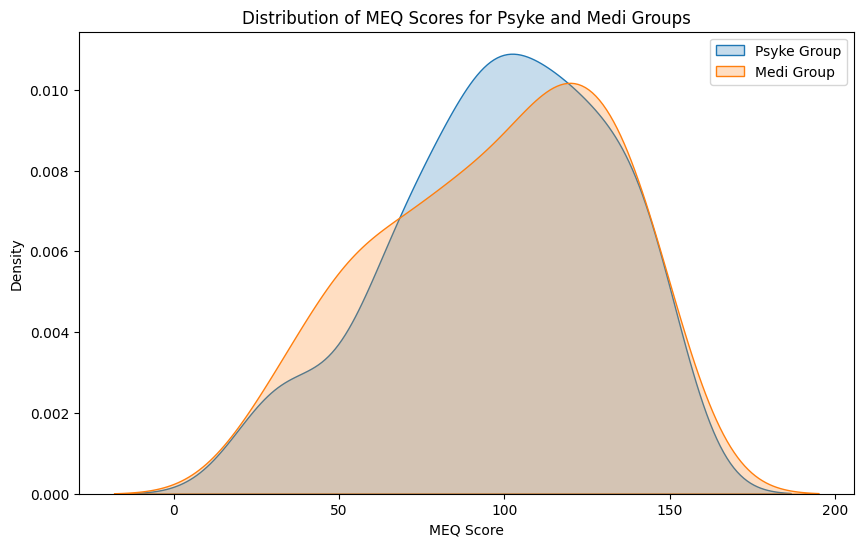

In [29]:
# Drop NaN values from MEQ30_sum for both groups
psyke_MEQ_clean = psyke['MEQ30_sum'].dropna()
medi_MEQ_clean = medi['MEQ30_sum'].dropna()

# Create a figure for plotting
plt.figure(figsize=(10, 6))

# Use seaborn to create a density plot
sns.kdeplot(psyke_MEQ_clean, label='Psyke Group', fill=True)
sns.kdeplot(medi_MEQ_clean, label='Medi Group', fill=True)

# Adding labels and title
plt.title('Distribution of MEQ Scores for Psyke and Medi Groups')
plt.xlabel('MEQ Score')
plt.ylabel('Density')

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()


In [30]:
# Calculate mean MEQ sum score for both groups
mean_MEQ_psyke = psyke['MEQ30_sum'].mean()
mean_MEQ_medi = medi['MEQ30_sum'].mean()

# Calculate standard deviation for MEQ sum scores for both groups
std_MEQ_psyke = psyke['MEQ30_sum'].std()
std_MEQ_medi = medi['MEQ30_sum'].std()

# Print the results for means and standard deviations
print(f"Mean MEQ sum score for Psyke group: {mean_MEQ_psyke:.2f} (stdev: {std_MEQ_psyke:.2f})")
print(f"Mean MEQ sum score for Medi group: {mean_MEQ_medi:.2f} (stdev: {std_MEQ_medi:.2f})")

# Test for normality before performing a t-test
from scipy.stats import shapiro
normality_psyke = shapiro(psyke['MEQ30_sum'].dropna())
normality_medi = shapiro(medi['MEQ30_sum'].dropna())
print(f"Normality test for Psyke group: Statistics={normality_psyke[0]:.3f}, p-value={normality_psyke[1]:.3f}")
print(f"Normality test for Medi group: Statistics={normality_medi[0]:.3f}, p-value={normality_medi[1]:.3f}")

from scipy.stats import mannwhitneyu

# Perform the Mann-Whitney U test
u_stat, p_value = mannwhitneyu(psyke['MEQ30_sum'].dropna(), medi['MEQ30_sum'].dropna())

print(f"Mann-Whitney U test results -- U statistic: {u_stat}, p-value: {p_value}")


Mean MEQ sum score for Psyke group: 98.72 (stdev: 32.46)
Mean MEQ sum score for Medi group: 97.46 (stdev: 34.41)
Normality test for Psyke group: Statistics=0.963, p-value=0.003
Normality test for Medi group: Statistics=0.953, p-value=0.017
Mann-Whitney U test results -- U statistic: 3711.0, p-value: 0.8644845934402602


### Checking word count distributions

In [31]:
total_words = df['Open_report typo-corrected'].str.split().apply(lambda x : len(x)).sum()
print(f"Total number of words in 'Open_report typo-corrected': {total_words}")


Total number of words in 'Open_report typo-corrected': 70734


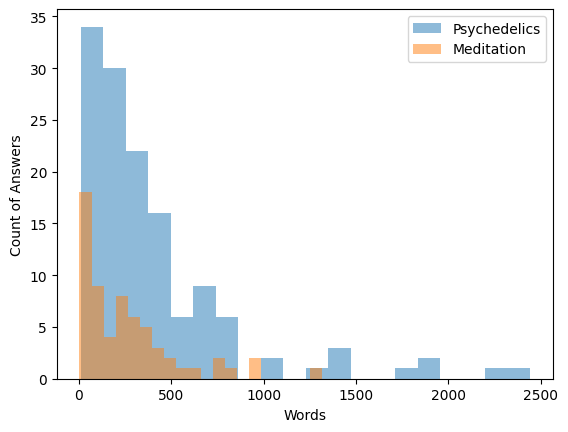

In [32]:
# Calculate the word counts per document for each group
words_psyke = psyke['Open_report typo-corrected'].str.split().apply(lambda x: len(x))
words_medi = medi['Open_report typo-corrected'].str.split().apply(lambda x: len(x))

# Plotting both histograms
plt.hist(words_psyke, bins=20, alpha=0.5, label='Psychedelics', color='C0')
plt.hist(words_medi, bins=20, alpha=0.5, label='Meditation', color='C1')

# Adding labels and title
plt.xlabel("Words")
plt.ylabel("Count of Answers")

# Display the legend
plt.legend()

# Show the plot
plt.show()

In [33]:
# Average length of the documents for all groups
avg_answer_length = round(df['Open_report typo-corrected'].str.split().apply(lambda x : len(x)).mean(), 2)
std_answer_length = round(df['Open_report typo-corrected'].str.split().apply(lambda x : len(x)).std(), 2)
print(f"Average length of answers in words for all groups: {avg_answer_length} (std: {std_answer_length})")

# Average length of the documents for 'psychedelics' group
avg_answer_length_psyke = round(psyke['Open_report typo-corrected'].str.split().apply(lambda x : len(x)).mean(), 2)
std_answer_length_psyke = round(psyke['Open_report typo-corrected'].str.split().apply(lambda x : len(x)).std(), 2)
print(f"Average length of answers in words for 'psychedelics' group: {avg_answer_length_psyke} (std: {std_answer_length_psyke})")

# Average length of the documents for 'meditation' group
avg_answer_length_medi = round(medi['Open_report typo-corrected'].str.split().apply(lambda x : len(x)).mean(), 2)
std_answer_length_medi = round(medi['Open_report typo-corrected'].str.split().apply(lambda x : len(x)).std(), 2)
print(f"Average length of answers in words for 'meditation' group: {avg_answer_length_medi} (std: {std_answer_length_medi})")


Average length of answers in words for all groups: 359.06 (std: 401.64)
Average length of answers in words for 'psychedelics' group: 400.69 (std: 444.78)
Average length of answers in words for 'meditation' group: 270.49 (std: 271.78)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/konsta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<BarContainer object of 10 artists>

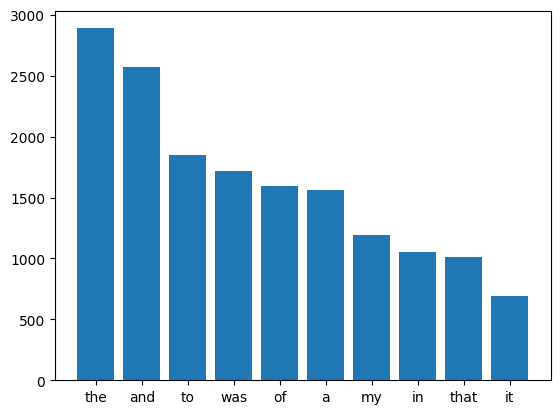

In [34]:
import nltk
nltk.download('stopwords')

# Visualising the most common stopwords in the dataset
stop_words = set(stopwords.words('english'))

corpus = []
words = df['Open_report typo-corrected'].str.split()
words = words.values.tolist()
corpus = [word for i in words for word in i]

from collections import defaultdict

dic=defaultdict(int)
for word in corpus:
    if word in stop_words:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y)

# Word frequency comparisons between the groups

In [35]:
from collections import Counter
import spacy
import sys

In [36]:
nlp = spacy.load("en_core_web_sm")

In [37]:
psyke_all_text = psyke['Open_report typo-corrected'].str.cat(sep=' ')

psyke_doc = nlp(psyke_all_text, disable=['ner'])

In [38]:
medi_all_text = medi['Open_report typo-corrected'].str.cat(sep=' ')

medi_doc = nlp(medi_all_text, disable=['ner'])


In [39]:
psyke_words = [token.lemma_ for token in psyke_doc if not token.is_stop and not token.is_punct and token.lemma_ != ' '] 
psyke_word_freq = Counter(psyke_words) 
psyke_word_freq.most_common(20)

[('feel', 546),
 ('experience', 376),
 ('like', 339),
 ('time', 233),
 ('start', 219),
 ('go', 171),
 ('friend', 157),
 ('life', 154),
 ('know', 139),
 ('think', 136),
 ('come', 134),
 ('take', 129),
 ('trip', 126),
 ('see', 123),
 ('thing', 112),
 ('get', 110),
 ('feeling', 105),
 ('remember', 105),
 ('look', 98),
 ('hour', 96)]

In [40]:
total_psyke_words = sum(psyke_word_freq.values())
print(f"Total words in Psyke dataset after processing: {total_psyke_words}")


Total words in Psyke dataset after processing: 21504


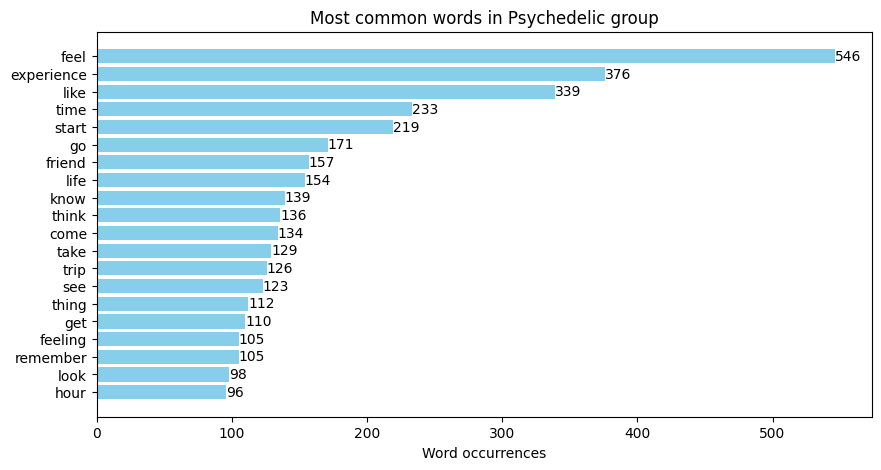

In [41]:
psyke_common_words = psyke_word_freq.most_common(20)
words, counts = zip(*psyke_common_words)

plt.figure(figsize=(10, 5))
bars = plt.barh(words, counts, color='skyblue')
plt.xlabel('Word occurrences')
plt.title('Most common words in Psychedelic group')
plt.gca().invert_yaxis()

# Add counts next to the bars
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f'{bar.get_width()}', 
             va='center', ha='left')

plt.show()


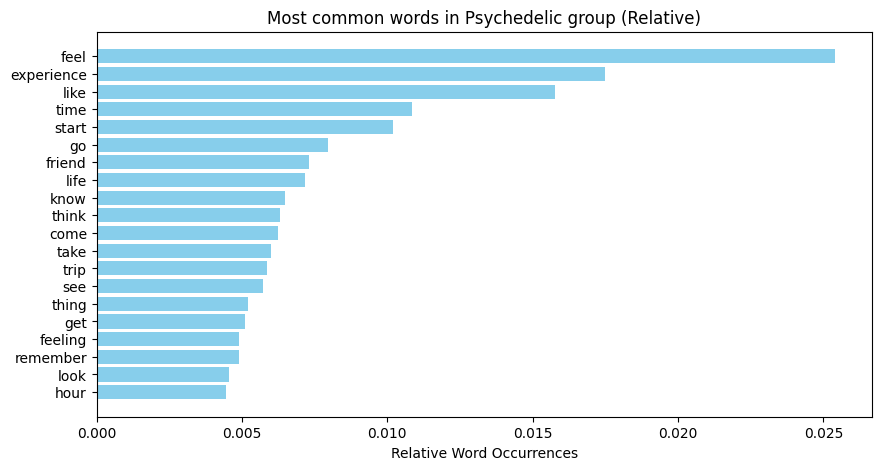

In [42]:
relative_psyke_counts = [count / total_psyke_words for count in counts]

plt.figure(figsize=(10, 5))
bars = plt.barh(words[::-1], relative_psyke_counts[::-1], color='skyblue')
plt.xlabel('Relative Word Occurrences')
plt.title('Most common words in Psychedelic group (Relative)')

plt.show()


In [43]:
medi_words = [token.lemma_ for token in medi_doc if not token.is_stop and not token.is_punct and token.lemma_ != ' '] 
medi_word_freq = Counter(medi_words) 
medi_word_freq.most_common(20)

[('experience', 184),
 ('feel', 145),
 ('like', 87),
 ('meditation', 83),
 ('time', 79),
 ('body', 68),
 ('day', 68),
 ('retreat', 55),
 ('practice', 51),
 ('life', 50),
 ('mind', 48),
 ('know', 41),
 ('come', 37),
 ('year', 37),
 ('happen', 35),
 ('love', 35),
 ('sense', 34),
 ('go', 34),
 ('start', 31),
 ('state', 31)]

In [44]:
total_medi_words = sum(medi_word_freq.values())
print(f"Total words in Medi dataset after processing: {total_medi_words}")

Total words in Medi dataset after processing: 7088


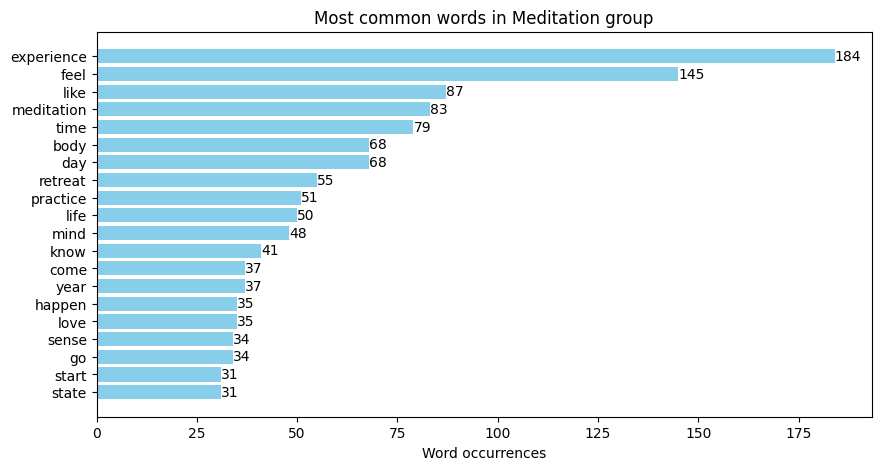

In [45]:
medi_common_words = medi_word_freq.most_common(20)
words, counts = zip(*medi_common_words)

plt.figure(figsize=(10, 5))
bars = plt.barh(words, counts, color='skyblue')
plt.xlabel('Word occurrences')
plt.title('Most common words in Meditation group')
plt.gca().invert_yaxis()

# Add counts next to the bars
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f'{bar.get_width()}', 
             va='center', ha='left')

plt.show()



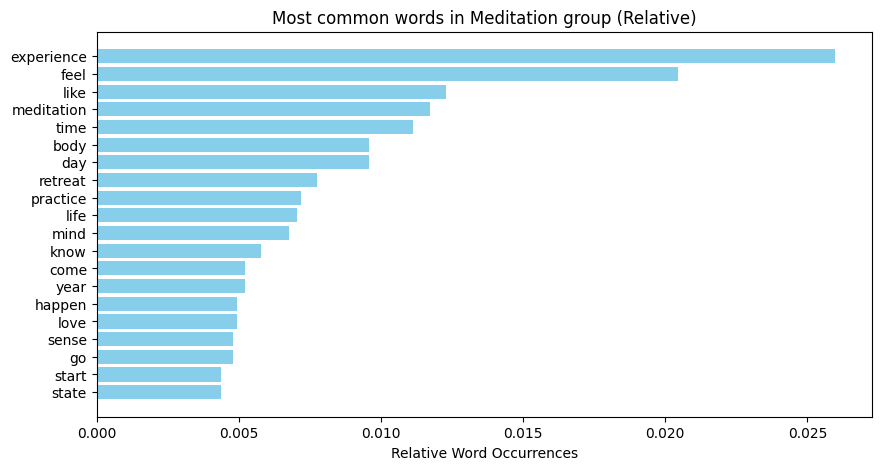

In [46]:
relative_medi_counts = [count / total_medi_words for count in counts]

plt.figure(figsize=(10, 5))
bars = plt.barh(words[::-1], relative_medi_counts[::-1], color='skyblue')
plt.xlabel('Relative Word Occurrences')
plt.title('Most common words in Meditation group (Relative)')

plt.show()


### Overlapping words and log-likelihood test for individual word frequencies across the groups 

In [47]:
# Create a set of all unique words in both corpora
all_words = set(psyke_word_freq.keys()) | set(medi_word_freq.keys())

In [48]:
# Showing the total and total unique words in both corpora
print(f"Unique words in psychedelic corpus: {len(psyke_word_freq)}")
print(f"Unique words in meditation corpus: {len(medi_word_freq)}")
print(f"Total unique words across both corpora: {len(all_words)}")
print(f"Total words in psychedelic corpus: {total_psyke_words}")
print(f"Total words in meditation corpus: {total_medi_words}")

# Calculate overlapping words
overlapping_words = set(psyke_word_freq.keys()) & set(medi_word_freq.keys())
overlapping_count = len(overlapping_words)
overlapping_share = overlapping_count / len(all_words)

print(f"Overlapping words count: {overlapping_count}")
print(f"Share of overlapping words: {overlapping_share:.2%}")

Unique words in psychedelic corpus: 4185
Unique words in meditation corpus: 2278
Total unique words across both corpora: 5058
Total words in psychedelic corpus: 21504
Total words in meditation corpus: 7088
Overlapping words count: 1405
Share of overlapping words: 27.78%


In [49]:
# Log-likelihood calculation
from scipy import stats

def log_likelihood(rel_freq1, rel_freq2, total1, total2):
    # Convert relative frequencies back to counts
    count1 = rel_freq1 * total1
    count2 = rel_freq2 * total2
    total = total1 + total2

    expected1 = total1 * (count1 + count2) / total
    expected2 = total2 * (count1 + count2) / total
    
    ll = 0
    if count1 > 0:
        ll += count1 * np.log(count1 / expected1)
    if count2 > 0:
        ll += count2 * np.log(count2 / expected2)
    
    return 2 * ll

In [50]:
word_stats = []

for word in all_words:
    psyke_count = psyke_word_freq.get(word, 0)
    medi_count = medi_word_freq.get(word, 0)
    
    # Calculate relative frequencies
    psyke_rel_freq = psyke_count / total_psyke_words
    medi_rel_freq = medi_count / total_medi_words
    
    
    ll_value = log_likelihood(psyke_rel_freq, medi_rel_freq, total_psyke_words, total_medi_words)
    
    # Calculate p-value
    p_value = 1 - stats.chi2.cdf(ll_value, 1)
    
    word_stats.append((word, ll_value, p_value, psyke_rel_freq, medi_rel_freq))

In [51]:
# Count statistically significant words
alpha = 0.05  # significance level
significant_count = sum(1 for _, _, p_value, _, _ in word_stats if p_value <= alpha)
total_words = len(word_stats)

# Calculate the share of significant words
significant_share = significant_count / total_words

print(f"Total words analyzed: {total_words}")
print(f"Number of statistically significant words: {significant_count}")
print(f"Share of statistically significant words: {significant_share:.2%}")


Total words analyzed: 5058
Number of statistically significant words: 440
Share of statistically significant words: 8.70%


### Comparing document vector embeddings from ada-002 

In [52]:
# Safety checks to ensure the embeddings work as expected 


# Check if embeddings are actually different between groups
print("First psychedelic embedding[:5]:", psyke['embedding'].iloc[0][:5])
print("First meditation embedding[:5]:", medi['embedding'].iloc[0][:5])

# Check if embeddings were properly loaded (not all identical)
print("\nNumber of unique embeddings in psychedelics:", 
      len(set(tuple(emb) for emb in psyke['embedding'])))
print("Number of unique embeddings in meditation:", 
      len(set(tuple(emb) for emb in medi['embedding'])))

# Check embedding dimensions
print("\nEmbedding dimension:", len(psyke['embedding'].iloc[0]))

First psychedelic embedding[:5]: [0.010056472, 0.006685716, 0.026913535, -0.03240127, -0.024156539]
First meditation embedding[:5]: [0.0020260897, -0.010788355, 0.023697723, 0.0036364875, -0.023029996]

Number of unique embeddings in psychedelics: 134
Number of unique embeddings in meditation: 63

Embedding dimension: 1536


In [53]:
# 1. Calculate average embeddings for each group
psyke_mean_embedding = np.mean(psyke['embedding'].tolist(), axis=0)
medi_mean_embedding = np.mean(medi['embedding'].tolist(), axis=0)

# 2. Calculate cosine similarity between group centroids
from sklearn.metrics.pairwise import cosine_similarity
group_similarity = cosine_similarity([psyke_mean_embedding], [medi_mean_embedding])[0][0]
print(f"Cosine similarity between group centroids: {group_similarity:.3f}")

# 3. Calculate within-group and between-group similarities
from itertools import combinations

def get_mean_pairwise_similarity(embeddings):
    sims = []
    for emb1, emb2 in combinations(embeddings, 2):
        sim = cosine_similarity([emb1], [emb2])[0][0]
        sims.append(sim)
    return np.mean(sims)

psyke_internal_similarity = get_mean_pairwise_similarity(psyke['embedding'].tolist())
medi_internal_similarity = get_mean_pairwise_similarity(medi['embedding'].tolist())

print(f"Average similarity within psychedelics group: {psyke_internal_similarity:.3f}")
print(f"Average similarity within meditation group: {medi_internal_similarity:.3f}")


Cosine similarity between group centroids: 0.972
Average similarity within psychedelics group: 0.839
Average similarity within meditation group: 0.838


# Creating pre-processed dataframes for both groups
Previously the stopwords were removed and words lemmatised while calculating the frequencies, but I didn't touch the actual dataframes. Now, we need preprocessed dataframes for TF-IDF, LDA and Sentiment analyses.  

In [54]:
lemmatizer = WordNetLemmatizer()
nltk.download('averaged_perceptron_tagger')

# Creating the pre-processing functions
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# Defining a mapping of words to their base forms
manual_mapping = {
    'felt': 'feel',
    'talked': 'talk',
    'thought': 'think',
}

def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [manual_mapping.get(token, token) for token in tokens] 
    tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens if token.isalpha() and token not in stop_words]
    return ' '.join(tokens)



[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/konsta/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [55]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/konsta/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/konsta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [56]:
# Pre-processing psyke and medi datasets

psyke_pre_processed_answers = psyke['Open_report typo-corrected'].apply(preprocess_text)
medi_pre_processed_answers = medi['Open_report typo-corrected'].apply(preprocess_text)



# TF-IDF analysis

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [58]:
# Count the number of words in psyke and medi datasets separately 
# This is used to check that the concatenation went right in the next step

# Function to count words in a dataset
def count_words(dataset):
    return sum(len(answer.split()) for answer in dataset)

# Counting words in psyke_pre_processed_answers
psyke_word_count = count_words(psyke_pre_processed_answers)
print(f"Total words in psyke dataset: {psyke_word_count}")

# Counting words in medi_pre_processed_answers
medi_word_count = count_words(medi_pre_processed_answers)
print(f"Total words in medi dataset: {medi_word_count}")


Total words in psyke dataset: 24277
Total words in medi dataset: 7831


In [59]:
# Combine psyke and medi datasets into one dataset for TF-IDF analysis
# Concatenate all psyke open answers into one string
psyke_combined_answers = " ".join(psyke_pre_processed_answers)
# Concatenate all medi open answers into one string
medi_combined_answers = " ".join(medi_pre_processed_answers)

# Create a new dataset with these combined answers
combined_dataset = pd.DataFrame({
    'dataset': ['psyke', 'medi'],
    'combined_answers': [psyke_combined_answers, medi_combined_answers]
})

combined_dataset

,dataset,combined_answers
0,psyke,friend apartment take lsd let say fairly avera...
1,medi,fundamental concept buddhism call anicca regar...


In [60]:
# Count the word counts of each combined_answers row
combined_dataset['word_count'] = combined_dataset['combined_answers'].apply(lambda x: len(x.split()))
combined_dataset


,dataset,combined_answers,word_count
0,psyke,friend apartment take lsd let say fairly avera...,24277
1,medi,fundamental concept buddhism call anicca regar...,7831


In [61]:
combined_dataset.drop(columns=['word_count'], inplace=True)
combined_dataset


,dataset,combined_answers
0,psyke,friend apartment take lsd let say fairly avera...
1,medi,fundamental concept buddhism call anicca regar...


In [62]:
# Custom TF-IDF Vectorizer without smoothing
class CustomTfidfVectorizer(TfidfVectorizer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def fit_transform(self, raw_documents, y=None):
        # Fit the model
        X = super().fit_transform(raw_documents, y=y)
        # Compute IDF without adding 1 to the denominator for smoothing
        self._tfidf.idf_ = np.log(X.shape[0] / np.bincount(X.nonzero()[1])) 
        # Transform the documents using the modified IDF
        return super().transform(raw_documents)

# Initialize the custom TF-IDF Vectorizer without smoothing
custom_tfidf_vectorizer = CustomTfidfVectorizer()

# Fit and transform the combined dataset
custom_tfidf_matrix = custom_tfidf_vectorizer.fit_transform(combined_dataset['combined_answers'])

# Convert the TF-IDF matrix to a dense DataFrame for easier manipulation and viewing
custom_df_tfidf = pd.DataFrame(custom_tfidf_matrix.todense(), columns=custom_tfidf_vectorizer.get_feature_names_out(), index=combined_dataset['dataset'])

# Display the custom TF-IDF DataFrame without smoothing
custom_df_tfidf

,abandon,abandonment,abdicate,abdomen,abide,ability,abject,able,abroad,absence,absent,absolute,absolutely,absorb,absorbance,absorbed,absorbs,abstract,abstraction,absurd,abundance,abuse,abusive,accept,acceptable,acceptance,accepted,access,accessible,accidentally,accommodate,accompanies,accompany,accord,account,accumulate,accumulates,accurate,accurately,accuse,ache,achievable,achieve,acid,acknowledge,acquaintance,acquire,across,act,action,activate,active,activity,actual,actually,acuity,acupressure,acute,adapt,add,addiction,addition,additional,address,adjust,administer,admit,admonishment,adolescent,adopt,adult,advaita,advance,advanced,adventure,adversity,advertise,advice,advise,affair,affect,affected,affection,afford,aforementioned,afraid,africa,aftereffect,afterglow,afternoon,afterward,afterwards,agapeschoolinz,agave,age,agency,agenda,aggressive,agitate,agitation,...,whereby,whether,whilst,whirl,whirlpool,whirlwind,whisper,whistle,white,whiée,whole,wholeness,whose,wicker,wide,wideness,wider,wife,wild,wilder,wilderness,will,willendorf,willful,william,willie,willing,willingness,win,wind,window,windy,wing,wintry,wire,wisdom,wise,wish,witch,witgehandschoend,withdraw,withhold,within,without,witness,wo,woke,woken,woman,wonder,wonderful,wonderland,wood,wooden,word,wordless,work,workshop,world,worldview,worm,wormhole,worn,worried,worry,worth,worthy,would,wound,woven,wow,wrap,wrinkle,wrist,write,writhe,wrong,yawn,yea,yeah,year,yearn,yell,yellow,yellowish,yes,yet,yin,yoga,yogi,yoginis,york,yorker,young,youth,youtube,zazen,zen,zero,zone
dataset,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
psyke,0.01826,0.004565,0.004565,0.004565,0.000000,0.0,0.004565,0.0,0.000000,0.000000,0.0,0.0,0.068477,0.004565,0.000000,0.00913,0.004565,0.013695,0.00913,0.01826,0.000000,0.01826,0.0,0.045651,0.000000,0.0,0.036521,0.0,0.000000,0.013695,0.004565,0.004565,0.0,0.022826,0.00913,0.004565,0.004565,0.000000,0.0,0.00913,0.000000,0.004565,0.0,0.0,0.004565,0.004565,0.0,0.0,0.0,0.0,0.0,0.004565,0.0,0.0,0.0,0.004565,0.004565,0.000000,0.004565,0.0,0.00913,0.004565,0.000000,0.0,0.00913,0.004565,0.004565,0.000000,0.004565,0.004565,0.0,0.000000,0.000000,0.0,0.013695,0.004565,0.000000,0.00913,0.0,0.000000,0.0,0.013695,0.0,0.004565,0.000000,0.041086,0.004565,0.004565,0.01826,0.0,0.000000,0.0,0.000000,0.004565,0.0,0.00913,0.000000,0.00913,0.004565,0.004565,...,0.000000,0.0,0.0,0.004565,0.004565,0.004565,0.0,0.004565,0.0,0.004565,0.0,0.000000,0.00913,0.000000,0.01826,0.000000,0.000000,0.0,0.013695,0.00913,0.004565,0.004565,0.004565,0.000000,0.004565,0.004565,0.004565,0.000000,0.004565,0.050216,0.0,0.0,0.00913,0.004565,0.004565,0.0,0.0,0.0,0.00913,0.004565,0.000000,0.000000,0.0,0.0,0.0,0.022826,0.0,0.004565,0.0,0.0,0.0,0.004565,0.022826,0.022826,0.0,0.000000,0.0,0.000000,0.0,0.004565,0.004565,0.000000,0.004565,0.0,0.0,0.00913,0.00913,0.0,0.000000,0.004565,0.022826,0.00913,0.00913,0.004565,0.0,0.013695,0.0,0.00913,0.004565,0.013695,0.0,0.01826,0.013695,0.0,0.004565,0.0,0.0,0.000000,0.0,0.000000,0.004565,0.004565,0.004565,0.0,0.004565,0.0,0.000000,0.0,0.000000,0.004565
medi,0.00000,0.000000,0.000000,0.000000,0.022617,0.0,0.000000,0.0,0.022617,0.045233,0.0,0.0,0.000000,0.000000,0.022617,0.00000,0.000000,0.000000,0.00000,0.00000,0.022617,0.00000,0.0,0.000000,0.022617,0.0,0.000000,0.0,0.022617,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.022617,0.0,0.00000,0.022617,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.022617,0.000000,0.0,0.00000,0.000000,0.022617,0.0,0.00000,0.000000,0.000000,0.022617,0.000000,0.000000,0.0,0.022617,0.022617,0.0,0.000000,0.000000,0.022617,0.00000,0.0,0.045233,0.0,0.000000,0.0,0.000000,0.022617,0.000000,0.000000,0.000000,0.00000,0.0,0.022617,0.0,0.022617,0.000000,0.0,0.00000,0.022617,0.00000,0.000000,0.000000,...,0.022617,0.0,0.0,0.

In [63]:
# Saving the top 20 words along with their TF-IDF scores for each group into variables

def get_top_n_words_custom_with_scores(df, n=20):
    top_words_scores_dict = {}
    for index, row in df.iterrows():
        top_n_words_scores = row.sort_values(ascending=False).head(n)
        top_words_scores_dict[index] = dict(top_n_words_scores)
    return top_words_scores_dict

# Get top 20 words and their TF-IDF scores for psyke and medi groups from the custom TF-IDF DataFrame
top_words_scores = get_top_n_words_custom_with_scores(custom_df_tfidf, 20)

# Saving top words and their scores for psyke and medi groups into separate variables including the scores
psyke_top_words_scores = top_words_scores['psyke']
medi_top_words_scores = top_words_scores['medi']

psyke_top_words_scores

{'trip': 0.5752045607974944,
 'lsd': 0.29673251152251695,
 'mushroom': 0.23738600921801356,
 'laugh': 0.14608369798031604,
 'psychedelics': 0.14151858241843118,
 'dose': 0.12325812017089166,
 'ceremony': 0.11412788904712191,
 'psilocybin': 0.10043254236146729,
 'visuals': 0.08673719567581265,
 'desert': 0.08673719567581265,
 'step': 0.08217208011392778,
 'loop': 0.08217208011392778,
 'smoke': 0.07304184899015802,
 'shape': 0.07304184899015802,
 'gram': 0.07304184899015802,
 'therapy': 0.07304184899015802,
 'hallucination': 0.06847673342827314,
 'absolutely': 0.06847673342827314,
 'anxious': 0.06847673342827314,
 'family': 0.06847673342827314}

In [64]:
# Filter out 'paralysis' from medi_top_words_scores if it exists
medi_top_words_scores = {k:v for k,v in medi_top_words_scores.items() if k != 'paralysis'}
medi_top_words_scores

{'nyams': 0.2261656365159491,
 'dzogchen': 0.20354907286435417,
 'arise': 0.18093250921275925,
 'technique': 0.15831594556116435,
 'ngondro': 0.15831594556116435,
 'garden': 0.13569938190956943,
 'divinity': 0.13569938190956943,
 'tradition': 0.11308281825797455,
 'spectrum': 0.11308281825797455,
 'occasion': 0.11308281825797455,
 'transmission': 0.11308281825797455,
 'yin': 0.09046625460637962,
 'lama': 0.09046625460637962,
 'personally': 0.09046625460637962,
 'practise': 0.09046625460637962,
 'roof': 0.09046625460637962,
 'empowerment': 0.09046625460637962,
 'compassionate': 0.09046625460637962,
 'prayer': 0.09046625460637962}

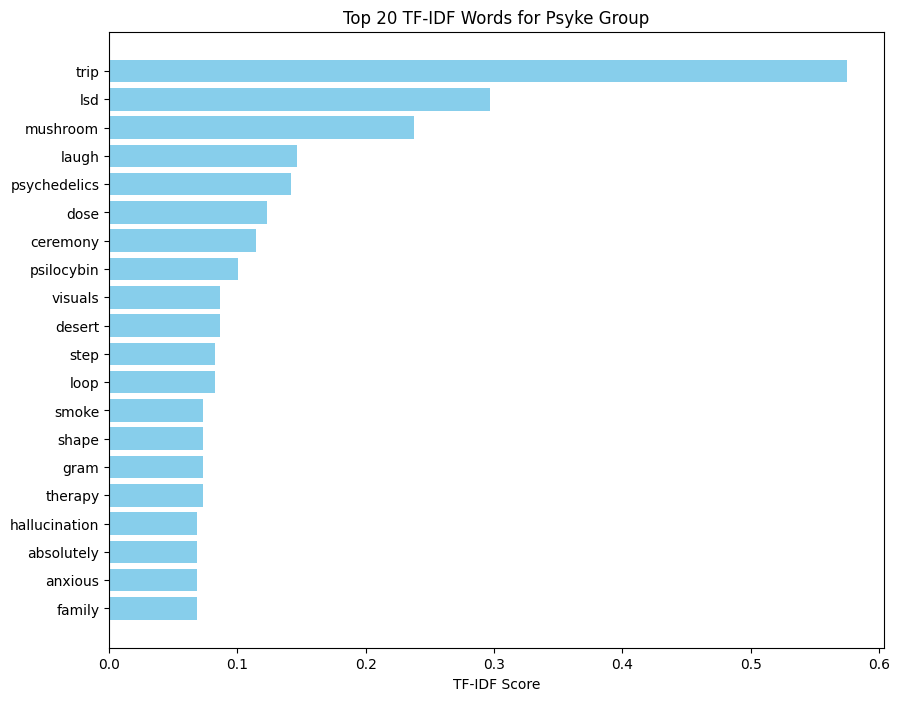

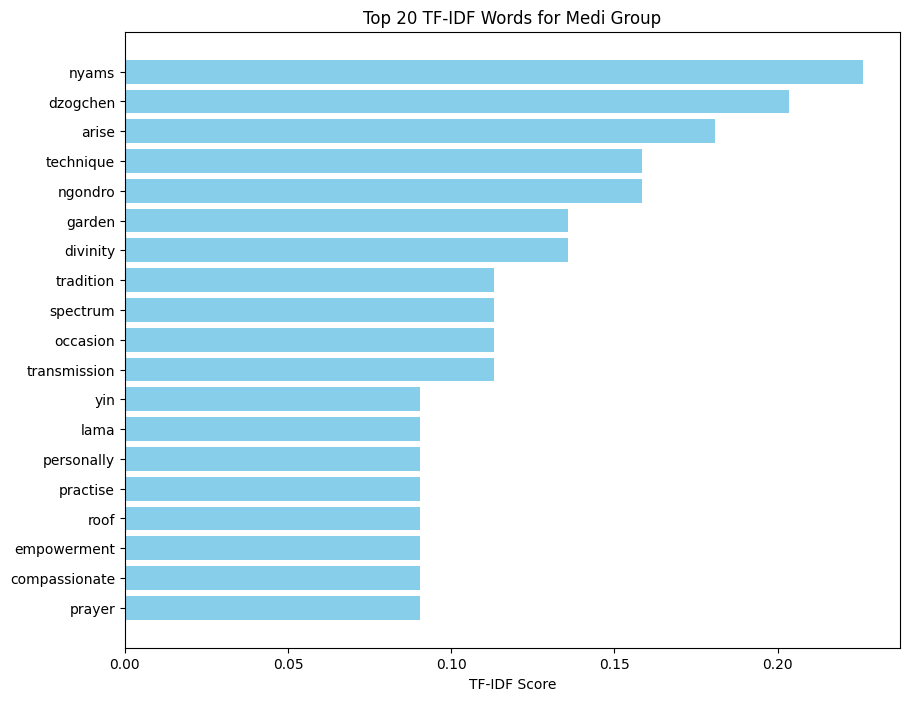

In [65]:
# Function to plot horizontal bar charts for the top words and their TF-IDF scores
def plot_top_words_horizontal(top_words_scores, group_name):
    words = list(top_words_scores.keys())
    scores = list(top_words_scores.values())
    
    plt.figure(figsize=(10, 8))
    y_pos = range(len(words))
    plt.barh(y_pos, scores, color='skyblue')
    plt.yticks(y_pos, words)
    plt.xlabel('TF-IDF Score')
    plt.title(f'Top 20 TF-IDF Words for {group_name} Group')
    plt.gca().invert_yaxis()  # To display the highest score at the top
    plt.show()

# Plotting for Psyke group
plot_top_words_horizontal(psyke_top_words_scores, 'Psyke')

# Plotting for Medi group
plot_top_words_horizontal(medi_top_words_scores, 'Medi')

# Topic analysis with LDA

### Number of topics (k) in LDA
Defined by using the model from Wheeler et al. (2021): https://link.springer.com/chapter/10.1007/978-3-030-74772-5_24. However, with meditation group the article's recommendations are not followed exactly (it suggests using only 2 topics for meditation), because I wanted to have same amount of topics for the both model, which also would make sense for human readers. Therefore, the k parameter is set to 5 with both datasets.

In [66]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Create vectorizer with min_df parameter
vectorizer_psyke = CountVectorizer(min_df=2)  # Only keep words that appear in at least 2 documents in order to avoid topics from only one document
psyke_dtm = vectorizer_psyke.fit_transform(psyke_pre_processed_answers)

# Create and fit LDA model with mostly default parameters
lda_model_psyke = LatentDirichletAllocation(
    n_components=5,
    random_state=42  # keeping this non-default for reproducibility
)
lda_model_psyke.fit(psyke_dtm)

# Do the same for meditation group
vectorizer_medi = CountVectorizer(min_df=2)
medi_dtm = vectorizer_medi.fit_transform(medi_pre_processed_answers)

lda_model_medi = LatentDirichletAllocation(
    n_components=5,
    random_state=42
)
lda_model_medi.fit(medi_dtm)

LatentDirichletAllocation(n_components=5, random_state=42)

In [67]:
def print_top_words(model, feature_names, n_top_words=10):
    """
    Print the top words for each topic in the LDA model as a comma-separated list.
    
    Parameters:
    -----------
    model : LatentDirichletAllocation
        The fitted LDA model
    feature_names : CountVectorizer
        The fitted vectorizer containing the vocabulary
    n_top_words : int, default=10
        Number of top words to print for each topic
    """
    # Get the feature names (words) from the vectorizer
    words = feature_names.get_feature_names_out()
    
    for topic_idx, topic in enumerate(model.components_):
        # Get the indices of top n words sorted by their weights in descending order
        top_words_idx = topic.argsort()[:-n_top_words-1:-1]
        # Get the actual words using the indices
        top_words = [words[i] for i in top_words_idx]
        
        # Join words with commas
        topic_words = ", ".join(top_words)
        print(f"Topic #{topic_idx + 1}: {topic_words}")


print("Psychedelics:")
print_top_words(lda_model_psyke, vectorizer_psyke)

print("\nMeditation:")
print_top_words(lda_model_medi, vectorizer_medi)

Psychedelics:
Topic #1: feel, experience, take, time, like, see, start, day, go, one
Topic #2: start, like, feel, go, friend, get, time, one, way, really
Topic #3: experience, feel, think, like, could, life, trip, one, take, remember
Topic #4: feel, like, experience, go, start, time, come, get, could, life
Topic #5: experience, feel, like, time, one, go, life, could, friend, remember

Meditation:
Topic #1: feel, body, experience, meditation, love, like, retreat, practice, go, day
Topic #2: experience, earth, father, meditation, feel, level, rainbow, meditate, time, could
Topic #3: experience, time, practice, feel, like, go, day, year, retreat, meditation
Topic #4: mind, think, experience, like, guru, get, could, ngondro, thought, teach
Topic #5: feel, experience, like, meditation, day, body, life, one, time, think


### Analysing the topics

In [68]:
# Get the topic distribution for each document
psyke_topic_distribution = lda_model_psyke.transform(psyke_dtm)

# Convert the topic distribution to a DataFrame
psyke_topic_distribution_df = pd.DataFrame(psyke_topic_distribution, columns=[f'Topic_{i+1}' for i in range(lda_model_psyke.n_components)])

# Concatenate the original DataFrame with the topic distribution DataFrame
psyke_with_topics = pd.concat([psyke_pre_processed_answers.reset_index(drop=True), psyke_topic_distribution_df], axis=1)

psyke_with_topics.head(5)

,Open_report typo-corrected,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5
0,friend apartment take lsd let say fairly avera...,0.266667,0.001826,0.001826,0.727852,0.001829
1,mean last experience take ketamine experienced...,0.166360,0.004072,0.086193,0.581914,0.161462
2,first time eat mushroom get away depression ay...,0.015877,0.015783,0.015752,0.015699,0.936889
3,close friend take shrooms nice walk around tow...,0.006595,0.332361,0.006566,0.647917,0.006560
4,many testimonial experienced connection nature...,0.003568,0.003582,0.063874,0.925381,0.003595


In [69]:
# Get the topic distribution for each document
medi_topic_distribution = lda_model_medi.transform(medi_dtm)

# Convert the topic distribution to a DataFrame
medi_topic_distribution_df = pd.DataFrame(medi_topic_distribution, columns=[f'Topic_{i+1}' for i in range(lda_model_medi.n_components)])

# Concatenate the original DataFrame with the topic distribution DataFrame
medi_with_topics = pd.concat([medi_pre_processed_answers.reset_index(drop=True), medi_topic_distribution_df], axis=1)

medi_with_topics.head(5)

,Open_report typo-corrected,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5
0,fundamental concept buddhism call anicca regar...,0.006591,0.006540,0.006620,0.006567,0.973682
1,developed positive feeling thought mind look l...,0.013594,0.013580,0.013709,0.013897,0.945219
2,recently lose father unexpectedly month funera...,0.005194,0.784746,0.005186,0.199682,0.005192
3,objective experience self voice separate entit...,0.004340,0.004282,0.982710,0.004305,0.004363
4,deep abide peace understand impermanence exper...,0.015968,0.016251,0.015625,0.015500,0.936655


In [70]:
# Calculate the average contribution of each topic for both Psyke and Medi
psyke_average_topic_contributions = psyke_topic_distribution_df.mean().round(3)
medi_average_topic_contributions = medi_topic_distribution_df.mean().round(3)

# Print the average contribution of each topic for both Psyke and Medi
print("Psyke average topic contributions:")
print(psyke_average_topic_contributions)
print("\nMedi average topic contributions:")
print(medi_average_topic_contributions)

Psyke average topic contributions:
Topic_1    0.153
Topic_2    0.102
Topic_3    0.073
Topic_4    0.458
Topic_5    0.215
dtype: float64

Medi average topic contributions:
Topic_1    0.170
Topic_2    0.119
Topic_3    0.249
Topic_4    0.060
Topic_5    0.402
dtype: float64


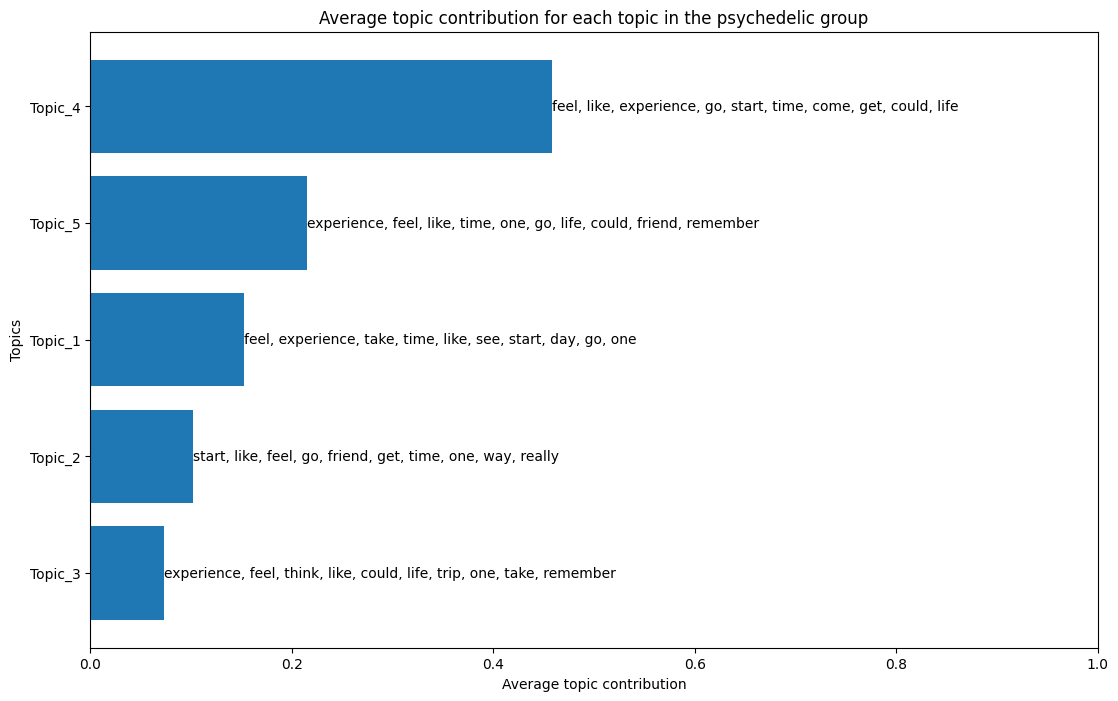

In [71]:
# Visualising the topic contributions with the top words

# Saving the top words into a dict
psyke_top_words_dict = {
    "Topic_1": "feel, experience, take, time, like, see, start, day, go, one",
    "Topic_2": "start, like, feel, go, friend, get, time, one, way, really",
    "Topic_3": "experience, feel, think, like, could, life, trip, one, take, remember",
    "Topic_4": "feel, like, experience, go, start, time, come, get, could, life",
    "Topic_5": "experience, feel, like, time, one, go, life, could, friend, remember"
}

# Creating the visualisation
sorted_topics_psyke = psyke_average_topic_contributions.sort_values(ascending=True)
fig, ax = plt.subplots(figsize=(13, 8))  # Adjust the size as needed
bars = ax.barh(sorted_topics_psyke.index, sorted_topics_psyke.values)

# Add top words next to the bars
for bar, topic in zip(bars, sorted_topics_psyke.index):
    ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, psyke_top_words_dict[topic], 
            va='center')  # Center the text vertically

ax.set_xlabel('Average topic contribution')
ax.set_ylabel('Topics')
ax.set_title('Average topic contribution for each topic in the psychedelic group')

# Set the limits of the x-axis
ax.set_xlim([0, 1])

plt.show()

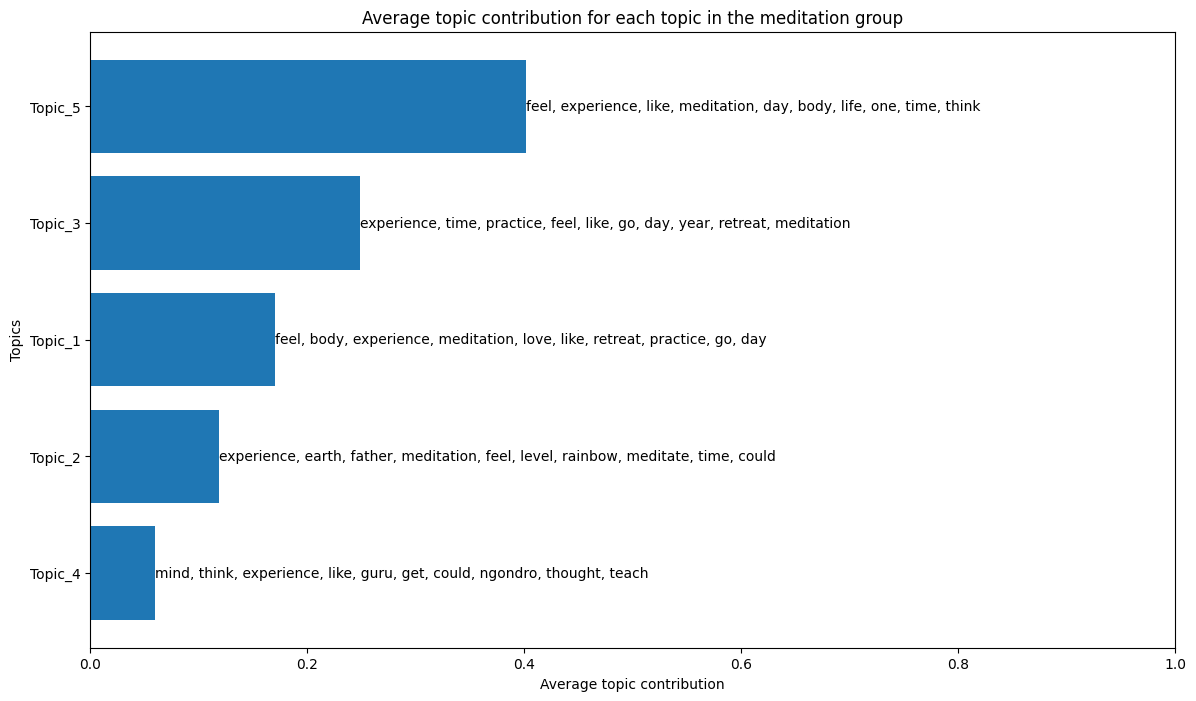

In [72]:
# Doing the same for medi topics

medi_top_words_dict = {
    "Topic_1": "feel, body, experience, meditation, love, like, retreat, practice, go, day",
    "Topic_2": "experience, earth, father, meditation, feel, level, rainbow, meditate, time, could", 
    "Topic_3": "experience, time, practice, feel, like, go, day, year, retreat, meditation",
    "Topic_4": "mind, think, experience, like, guru, get, could, ngondro, thought, teach",
    "Topic_5": "feel, experience, like, meditation, day, body, life, one, time, think"
}

# Visualising the topic contributions for medi
sorted_topics_medi = medi_average_topic_contributions.sort_values(ascending=True)
fig, ax = plt.subplots(figsize=(14, 8))  # Adjust the size as needed
bars = ax.barh(sorted_topics_medi.index, sorted_topics_medi.values)

# Add top words next to the bars
for bar, topic in zip(bars, sorted_topics_medi.index):
    ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, medi_top_words_dict[topic], 
            va='center')  # Center the text vertically

ax.set_xlabel('Average topic contribution')
ax.set_ylabel('Topics')
ax.set_title('Average topic contribution for each topic in the meditation group')

# Set the limits of the x-axis
ax.set_xlim([0, 1])


plt.show()

# Sentiment analysis

In [73]:
from nltk.sentiment import SentimentIntensityAnalyzer

In [74]:
try:
    sia = SentimentIntensityAnalyzer()
except LookupError:
    nltk.download('vader_lexicon')
    sia = SentimentIntensityAnalyzer()


In [75]:
# Adding sentiment scores to both dataframes

# Create copies to avoid SettingWithCopyWarning
psyke_copy = psyke.copy()
medi_copy = medi.copy()

# Calculate sentiment scores for psychedelics group
sentiment_scores_psyke = psyke_copy['Open_report typo-corrected'].apply(lambda x: sia.polarity_scores(x))
psyke_copy['sentiment_scores'] = sentiment_scores_psyke
psyke_copy['compound_sentiment'] = sentiment_scores_psyke.apply(lambda x: x['compound'])
psyke_copy['positive_sentiment'] = sentiment_scores_psyke.apply(lambda x: x['pos'])
psyke_copy['neutral_sentiment'] = sentiment_scores_psyke.apply(lambda x: x['neu']) 
psyke_copy['negative_sentiment'] = sentiment_scores_psyke.apply(lambda x: x['neg'])

# Calculate sentiment scores for meditation group
sentiment_scores_medi = medi_copy['Open_report typo-corrected'].apply(lambda x: sia.polarity_scores(x))
medi_copy['sentiment_scores'] = sentiment_scores_medi
medi_copy['compound_sentiment'] = sentiment_scores_medi.apply(lambda x: x['compound'])
medi_copy['positive_sentiment'] = sentiment_scores_medi.apply(lambda x: x['pos'])
medi_copy['neutral_sentiment'] = sentiment_scores_medi.apply(lambda x: x['neu'])
medi_copy['negative_sentiment'] = sentiment_scores_medi.apply(lambda x: x['neg'])

# Reassign back to original variables
psyke = psyke_copy
medi = medi_copy

psyke[['compound_sentiment', 'positive_sentiment', 'neutral_sentiment', 'negative_sentiment']].head(2)

,compound_sentiment,positive_sentiment,neutral_sentiment,negative_sentiment
63,0.9826,0.140,0.841,0.018
64,0.5668,0.098,0.843,0.059


In [76]:
medi[['compound_sentiment', 'positive_sentiment', 'neutral_sentiment', 'negative_sentiment']].head(2)

,compound_sentiment,positive_sentiment,neutral_sentiment,negative_sentiment
0,0.3182,0.035,0.965,0.0
1,0.8689,0.282,0.718,0.0


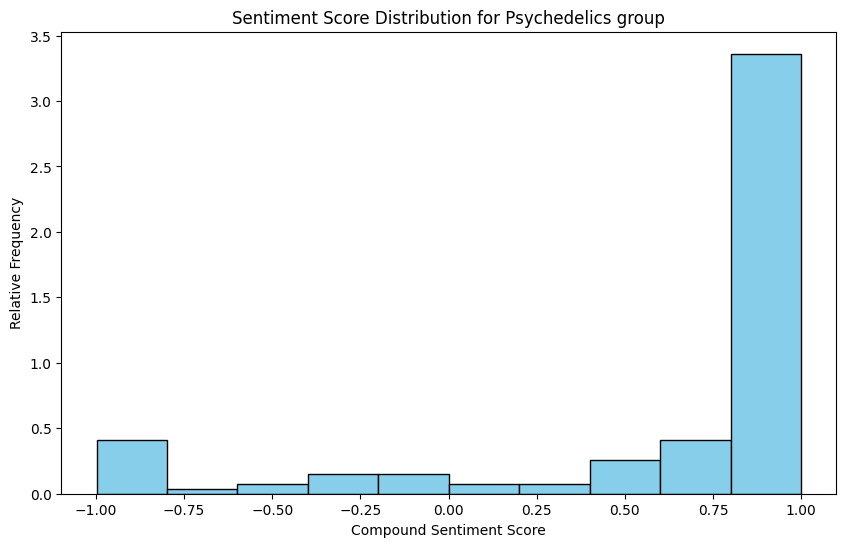

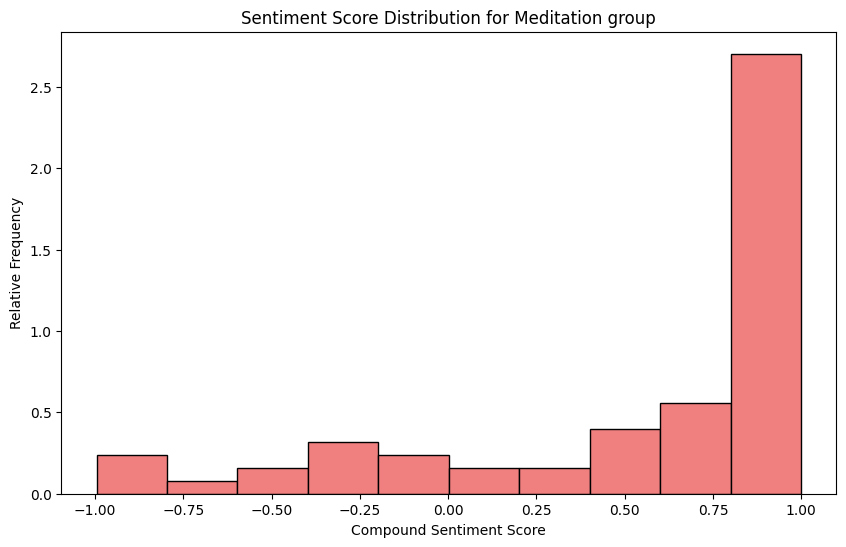

In [77]:
# Creating a sentiment histogram for Psychedelics group
plt.figure(figsize=(10,6))
plt.hist(psyke['compound_sentiment'], bins=10, color='skyblue', edgecolor='black', density=True)

# Add labels and a title
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Relative Frequency')
plt.title('Sentiment Score Distribution for Psychedelics group')

# Show the plot
plt.show()

# Creating a sentiment histogram for Meditation group
plt.figure(figsize=(10,6))
plt.hist(medi['compound_sentiment'], bins=10, color='lightcoral', edgecolor='black', density=True)

# Add labels and a title
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Relative Frequency')
plt.title('Sentiment Score Distribution for Meditation group')

# Show the plot
plt.show()

/var/folders/mn/1s5j3ljx1c796bd743f0ymxh0000gn/T/ipykernel_96621/2236872054.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='Compound Sentiment Score', data=box_plot_data, palette=['skyblue', 'lightcoral'])


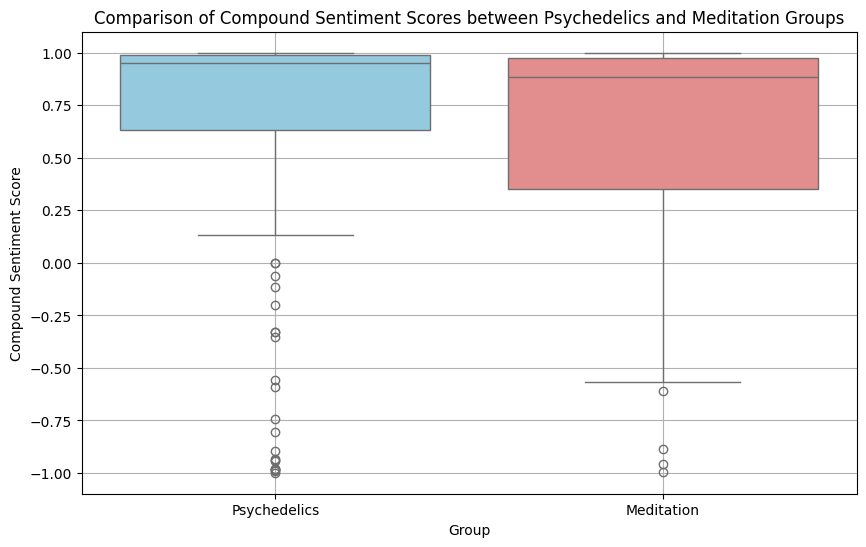

In [78]:
# Box plots

box_plot_data = pd.DataFrame({
    'Group': ['Psychedelics'] * len(psyke) + ['Meditation'] * len(medi),
    'Compound Sentiment Score': pd.concat([psyke['compound_sentiment'], medi['compound_sentiment']], ignore_index=True)
})

plt.figure(figsize=(10,6))
sns.boxplot(x='Group', y='Compound Sentiment Score', data=box_plot_data, palette=['skyblue', 'lightcoral'])
plt.title('Comparison of Compound Sentiment Scores between Psychedelics and Meditation Groups')
plt.grid(True)
plt.show()


In [79]:
from scipy.stats import normaltest

# Normality test for Psychedelics group
psyke_compound_normality = normaltest(psyke['compound_sentiment'])
psyke_positive_normality = normaltest(psyke['positive_sentiment'])
psyke_neutral_normality = normaltest(psyke['neutral_sentiment'])
psyke_negative_normality = normaltest(psyke['negative_sentiment'])

print("Psychedelics Group Normality Test Results:")
print(f"Compound Sentiment: Statistic={psyke_compound_normality.statistic}, P-value={psyke_compound_normality.pvalue}")
print(f"Positive Sentiment: Statistic={psyke_positive_normality.statistic}, P-value={psyke_positive_normality.pvalue}")
print(f"Neutral Sentiment: Statistic={psyke_neutral_normality.statistic}, P-value={psyke_neutral_normality.pvalue}")
print(f"Negative Sentiment: Statistic={psyke_negative_normality.statistic}, P-value={psyke_negative_normality.pvalue}")

# Normality test for Meditation group
medi_compound_normality = normaltest(medi['compound_sentiment'])
medi_positive_normality = normaltest(medi['positive_sentiment'])
medi_neutral_normality = normaltest(medi['neutral_sentiment'])
medi_negative_normality = normaltest(medi['negative_sentiment'])

print("\nMeditation Group Normality Test Results:")
print(f"Compound Sentiment: Statistic={medi_compound_normality.statistic}, P-value={medi_compound_normality.pvalue}")
print(f"Positive Sentiment: Statistic={medi_positive_normality.statistic}, P-value={medi_positive_normality.pvalue}")
print(f"Neutral Sentiment: Statistic={medi_neutral_normality.statistic}, P-value={medi_neutral_normality.pvalue}")
print(f"Negative Sentiment: Statistic={medi_negative_normality.statistic}, P-value={medi_negative_normality.pvalue}")


Psychedelics Group Normality Test Results:
Compound Sentiment: Statistic=47.3696135405236, P-value=5.173912916667312e-11
Positive Sentiment: Statistic=19.84408549058257, P-value=4.908079475054461e-05
Neutral Sentiment: Statistic=13.187551285932164, P-value=0.0013688618607825896
Negative Sentiment: Statistic=28.03185803635102, P-value=8.183882185076458e-07

Meditation Group Normality Test Results:
Compound Sentiment: Statistic=14.777840687897013, P-value=0.0006180628887525084
Positive Sentiment: Statistic=20.44460902812086, P-value=3.635043038379674e-05
Neutral Sentiment: Statistic=5.106839611512997, P-value=0.07781509793558232
Negative Sentiment: Statistic=70.73378863160491, P-value=4.368707383498498e-16


### Sentiment scores by the group

In [80]:
# Difference in different sentiments

psyke_avg_comp = round(psyke['compound_sentiment'].mean(), 2)
psyke_std_comp = round(psyke['compound_sentiment'].std(), 2)

medi_avg_comp = round(medi['compound_sentiment'].mean(), 2)
medi_std_comp = round(medi['compound_sentiment'].std(), 2)

print('Psychedelics average compound score: '+str(psyke_avg_comp)+ ' ('+str(psyke_std_comp) +').')
print('Meditation average compound score: '+str(medi_avg_comp)+ ' ('+str(medi_std_comp)+').')

psyke_avg_pos = round(psyke['positive_sentiment'].mean(), 2)
psyke_std_pos = round(psyke['positive_sentiment'].std(), 2)

medi_avg_pos = round(medi['positive_sentiment'].mean(), 2)
medi_std_pos = round(medi['positive_sentiment'].std(), 2)

print('Psychedelics average positive score: '+str(psyke_avg_pos)+ ' ('+str(psyke_std_pos) +').')
print('Meditation average positive score: '+str(medi_avg_pos)+ ' ('+str(medi_std_pos)+').')

psyke_avg_neg = round(psyke['negative_sentiment'].mean(), 2)
psyke_std_neg = round(psyke['negative_sentiment'].std(), 2)

medi_avg_neg = round(medi['negative_sentiment'].mean(), 2)
medi_std_neg = round(medi['negative_sentiment'].std(), 2)

print('Psychedelics average negative score: '+str(psyke_avg_neg)+ ' ('+str(psyke_std_neg) +').')
print('Meditation average negative score: '+str(medi_avg_neg)+ ' ('+str(medi_std_neg)+').')

psyke_avg_neu = round(psyke['neutral_sentiment'].mean(), 2)
psyke_std_neu = round(psyke['neutral_sentiment'].std(), 2)

medi_avg_neu = round(medi['neutral_sentiment'].mean(), 2)
medi_std_neu = round(medi['neutral_sentiment'].std(), 2)

print('Psychedelics average neutral score: '+str(psyke_avg_neu)+ ' ('+str(psyke_std_neu) +').')
print('Meditation average neutral score: '+str(medi_avg_neu)+ ' ('+str(medi_std_neu)+').')


Psychedelics average compound score: 0.63 (0.61).
Meditation average compound score: 0.56 (0.59).
Psychedelics average positive score: 0.15 (0.08).
Meditation average positive score: 0.13 (0.08).
Psychedelics average negative score: 0.07 (0.05).
Meditation average negative score: 0.06 (0.07).
Psychedelics average neutral score: 0.78 (0.09).
Meditation average neutral score: 0.81 (0.09).


### Mann-Whitney U-tests for pairwise comparisons
The sentiment distributions are heavily skewed, so let's use a non-parametric test for the pairwise comparisons. 

In [81]:
from scipy.stats import mannwhitneyu

# Calculate U-statistics and p-values

u_stat_comp, p_val_comp = mannwhitneyu(psyke['compound_sentiment'], medi['compound_sentiment'])
u_stat_pos, p_val_pos = mannwhitneyu(psyke['positive_sentiment'], medi['positive_sentiment'])
u_stat_neg, p_val_neg = mannwhitneyu(psyke['negative_sentiment'], medi['negative_sentiment'])
u_stat_neu, p_val_neu = mannwhitneyu(psyke['neutral_sentiment'], medi['neutral_sentiment'])

# Print U-statistics and p-values
print("Compound sentiment: U-statistic = ", u_stat_comp, ", p-value = ", p_val_comp)
print("Positive sentiment: U-statistic = ", u_stat_pos, ", p-value = ", p_val_pos)
print("Negative sentiment: U-statistic = ", u_stat_neg, ", p-value = ", p_val_neg)
print("Neutral sentiment: U-statistic = ", u_stat_neu, ", p-value = ", p_val_neu)


Compound sentiment: U-statistic =  4917.0 , p-value =  0.06238751856203346
Positive sentiment: U-statistic =  5097.5 , p-value =  0.018911563912330488
Negative sentiment: U-statistic =  5265.0 , p-value =  0.005152305858431993
Neutral sentiment: U-statistic =  3270.5 , p-value =  0.010912510471445359


https://tools.carbocation.com/FDR was used for calculating the adjusted p-values

In [82]:
# Calculating effect sizes for the differences in sentiments

from scipy.stats import norm

# Calculate the mean and standard deviation of U
n1 = len(psyke['compound_sentiment'])
n2 = len(medi['compound_sentiment'])
mean_U = n1 * n2 / 2
std_dev_U = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)

# Calculate the z-scores
z_comp = (u_stat_comp - mean_U) / std_dev_U
z_pos = (u_stat_pos - mean_U) / std_dev_U
z_neg = (u_stat_neg - mean_U) / std_dev_U
z_neu = (u_stat_neu - mean_U) / std_dev_U

# Calculate the effect sizes
r_comp = round(z_comp / np.sqrt(n1 + n2), 3)
r_pos = round(z_pos / np.sqrt(n1 + n2), 3)
r_neg = round(z_neg / np.sqrt(n1 + n2), 3)
r_neu = round(z_neu / np.sqrt(n1 + n2), 3)

# Print the effect sizes
print("Compound sentiment: r =", r_comp)
print("Positive sentiment: r =", r_pos)
print("Negative sentiment: r =", r_neg)
print("Neutral sentiment: r =", r_neu)

Compound sentiment: r = 0.133
Positive sentiment: r = 0.167
Negative sentiment: r = 0.199
Neutral sentiment: r = -0.181
